In [3]:
# Version 2.2 (automated removal experiments) - new PN Activity representation (binomial dist.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pickle
import scipy.stats as st
import copy

# read csv 
df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FUNCTIONS

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# Sets the bias for a single KC so that the KC fires 5% of 
# the time in response to any odor
# inputs - array of all points from all odors
# weights - array of weights (aka synapses) for a single KC
def set_kc_bias(inputs, weights):
    I = len(inputs)
    bias = 0
    
    kc_output = np.zeros((I,)) # array to store output values
    
    # loops thru all inputs and calculates and stores the KC output value
    for i in range(I):
        point = inputs[i]
        #print("point:\n{}, length: {}".format(point, len(point)))

        # equation
        x = np.dot(point, weights) # no bias yet (theta=0)
        #print("output value: {}".format(x))

        kc_output[i] = x  # add output value to output array
    
    kc_output.sort() # sort output values in ascending order
    #print("output values of single KC after sorting:\n{} \nlength: {}".format(kc_output, len(kc_output)))
    idx = int(0.05 * len(kc_output)) # getting index for the threshold that'll provide a 5% firing rate (out of 5000, this is the 251th output value with index of 250)
    #print("index: ", idx)
    bias = kc_output[idx]
    #print("bias: ", bias)
    
    return bias

# Calculates output of KC layer
# weights - weights (num of synapses) for connections from PNs to KCs
# biases - biases
# inputs - inputs from PNs
def build_pn_to_kc(inputs, weights, biases):
    
    # equation
    x1 = np.dot(inputs, weights) + biases # matrix multiplication to multiply inputs by weights
    #print("after matrix multiplication:\n{}, \nlength: {}".format(x1, len(x1)))

    # thresholding
    x1 = np.where(x1 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x1, len(x1)))
    
    return x1

# Calculates output of MBON layer
# weights - weights (num of synapses) from KC to MBON
# inputs - inputs from KCs
# bias - biases
def build_kc_to_mbon(inputs, weights, bias):
    
    # equation
    x2 = np.dot(inputs, weights) + bias
    #print("after matrix multiplication:\n{}, \nnum of rows: {}".format(x2, len(x2)))

    # thresholding
    x2 = np.where(x2 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x2, len(x2)))
    
    return x2

# Randomly prunes a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def prune_rand_kcs(df, num):
    num_mbons = len(df.columns)
    kc_names = []
    
    # loop thru each column = MBON
    for m in range(num_mbons):        
        idxs_with_conn = np.asarray(np.where(df.iloc[:,m] > 0)).flatten() # gets indicies where there is a connection to a KC
        
        # randomly select KC connections to be removed
        s = num
        if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
            s = len(idxs_with_conn)
        indicies = np.random.choice(a=idxs_with_conn, size=s, replace=False)
        
        kc_names.append(df.index[indicies]) # record names of KCs
        
        for i in indicies:
            df.iloc[i, m] = 0
    
    df = df.to_numpy()
    return df, kc_names

# # Targeted pruning prunes KC connections for each MBON based on their synaptic weight value
# # Returns the new weight table (df) and the names of KCs with connections set to zero in each MBON
# # df - synapse table
# # num - number of KCs to remove
# def prune_top_kcs(prev_w, curr_w, num, run):
#     num_mbons = 19
#     kc_names = []
#     names = list(curr_w.index)
#     print(type(curr_w))
    
#     # loop thru each column = MBON
#     for m in range(num_mbons):
#         if m < num_mbons:
#             vals = abs(prev_w[run,:,m]) # absolute value of column
#             idxs_with_conn = np.asarray(np.where(vals > 0)).flatten() # gets indicies where there is a connection to a KC

#             # find KC connections with highest weight values to remove
#             s = num
#             if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
#                 s = len(idxs_with_conn)
#             top_weight_idx = np.argpartition(vals, -1*s)[-1*s:] # gets indicies of top #num KC connections

# #             print(type(top_weight_idx))
#             kc_names = np.array(names)[top_weight_idx] # names of KC connections pruned

#     #         curr_w = curr_w
#             for i in top_weight_idx:
#                 curr_w[i, m] = 0 # sets weight values of KC connections to be removed to zero

#     return curr_w, kc_names

# ORIGINAL prune_top_kcs function
# Targeted pruning prunes KC connections for each MBON based on their synaptic weight value
# Returns the new weight table (df) and the names of KCs with connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def prune_top_kcs(prev_w, curr_w, num, run):
    num_mbons = 19
    kc_names = []
    print(prev_w.shape)
    
    # loop thru each column = MBON
    for m in range(0,num_mbons):
        vals = abs(prev_w[run,:,m]) # absolute value of column
        idxs_with_conn = np.asarray(np.where(vals > 0)).flatten() # gets indicies where there is a connection to a KC
        
        # find KC connections with highest weight values to remove
        s = num
        if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
            s = len(idxs_with_conn)
        top_weight_idx = np.argpartition(vals, -1*s)[-1*s:] # gets indicies of top #num KC connections
        
        kc_names = list(curr_w.index[top_weight_idx]) # names of KC connections pruned
    
#         curr_w = curr_w.to_numpy()
        curr_w.iloc[top_weight_idx, m] = 0 # sets weight values of KC connections to be removed to zero

    return curr_w.to_numpy(), kc_names

# Randomly ablates a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def ablate_rand_kcs(df, num):
    num_mbons = len(df.columns)
    num_kcs = len(df)
    kc_names = []    
        
    # randomly select KC connections to be removed
    indicies = random.choice(num_kcs, size=num, replace=False)
    kc_names.append(df.index[indicies]) # record names of KCs
    # sets each row (= each KC) in indices to zero
    for i in indicies:
        df.iloc[i, :] = 0
    
    df = df.to_numpy()
    return df, kc_names

# Sets the all synaptic weight values of the top certain number of KCs to zero. Returns new weight table with
# KCs removed and a list of names of the KCs removed
# prev_w - weight table from previous run (np arr)
# curr_w - current weight table (df as input, return as np array)
# num - the number of KCs' connections to remove
# run - the realization (eg. 0, 1, 2...)
def ablate_top_kcs(prev_w, curr_w, num, run):
    sum_weights = abs(prev_w[run]).sum(axis=1) # total absolute value of final weights for each KC 
    top_weight_idx = np.argpartition(sum_weights, -1*num)[-1*num:]
    
    # record which KCs are removed
    kc_names = list(curr_w.index[top_weight_idx])
    
    curr_w = curr_w.to_numpy()
    curr_w[top_weight_idx,:] = 0 # sets weight values of KCs to be removed to zero
    
    return curr_w, kc_names

In [4]:
# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)
#pn_kc = pn_kc.fillna(0)

pn_kc

1 claw KC left  1 claw KC left.1  1 claw KC left.2  \
Presynaptic PNs                                                                 
1a PN left                            0.0               0.0               0.0   
13a PN left                           0.0               0.0               0.0   
22c PN left                           0.0               0.0               0.0   
24a PN left                           0.0               0.0               0.0   
30a PN left                           0.0               0.0               0.0   
33a PN left                           0.0               0.0               0.0   
35a PN bilateral left                 0.0               0.0               0.0   
42a PN left                           0.0               0.0               0.0   
42b PN left                           0.0               0.0               0.0   
45a PN left                           0.0               0.0               0.0   
45b PN left                           1.0               0.0               0.0   
47a & 33b PN left                     0.0               0.0               0.0   
49a PN left                           0.0               0.0               1.0   
59a PN left                           0.0               0.0               0.0   
63a PN left                           0.0               0.0               0.0   
67b PN left                           0.0               1.0               0.0   
74a PN left                           0.0               0.0               0.0   
82a PN left                           0.0               0.0               0.0   
83a PN left                           0.0               0.0               0.0   
85c PN left                           0.0               0.0               0.0   
94a & 94b PN left                     0.0               0.0               0.0   
Gustatory PN 1 left                   0.0               0.0               0.0   
Gustatory PN 2 left                   0.0               0.0               0.0   
Gustatory PN 3 left                   0.0               0.0               0.0   
Gustatory PN 4 left                   0.0               0.0               0.0   
Multiglomerular PN 1 left             0.0               0.0               0.0   
Multiglomerular PN 2 left             0.0               0.0               0.0   
Multiglomerular PN 3 left             0.0               0.0               0.0   
Multiglomerular PN 4 left             0.0               0.0               0.0   
Multiglomerular PN 5 left             0.0               0.0               0.0   
Unkown PN 1 left                      0.0               0.0               0.0   
Unkown PN 2 left                      0.0               0.0               0.0   
Thermo PN 1 left                      0.0               0.0               0.0   
Thermo PN 2 left                      0.0               0.0               0.0   
Thermo PN 3 left                      0.0               0.0               0.0   
Thermo PN 4 left                      0.0               0.0               0.0   
Vision PN 1 left                      0.0               0.0               0.0   
Thermo PN 6 left                      0.0               0.0               0.0   
Thermo PN 7 left                      0.0               0.0               0.0   
Thermo PN 8 left                      0.0               0.0               0.0   

                           1 claw KC left.3  1 claw KC left.4  \
Presynaptic PNs                                                 
1a PN left                              0.0          0.000000   
13a PN left                             0.0          0.105263   
22c PN left                             0.0          0.000000   
24a PN left                             0.0          0.000000   
30a PN left                             0.0          0.000000   
33a PN left                             0.0          0.000000   
35a PN bilateral left                   0.0          0.894737   
42a PN left                            

In [5]:
# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

kc_mbon

MBON-a1 left  MBON-a2 left  MBON-b1 left  MBON-b2 left  \
Presynaptic KCs                                                           
1 claw KC left       0.014286      0.011416      0.036723      0.019663   
1 claw KC left       0.028571      0.009132      0.042373      0.042135   
1 claw KC left       0.035714      0.009132      0.028249      0.039326   
1 claw KC left       0.039286      0.011416      0.067797      0.056180   
1 claw KC left       0.010714      0.006849      0.033898      0.022472   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   

                 MBON-c1 left  MBON-d1 left  MBON-e1 left  MBON-e2 left  \
Presynaptic KCs                                                           
1 claw KC left       0.034662      0.024450      0.033386      0.052632   
1 claw KC left       0.023397      0.031785      0.027027      0.022556   
1 claw KC left       0.019064      0.022005      0.019078      0.030075   
1 claw KC left       0.033795      0.022005      0.030207      0.045113   
1 claw KC left       0.054593      0.034230      0.012719      0.000000   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   

                 MBON-g1 left  MBON-g2 left  MBON-h1 left  MBON-h2 left  \
Presynaptic KCs                                                           
1 claw KC left       0.015595      0.014894      0.020761      0.025974   
1 claw KC left       0.031189      0.023404      0.006920      0.018182   
1 claw KC left       0.021442      0.019149      0.020761      0.023377   
1 claw KC left       0.025341      0.008511      0.024221      0.036364   
1 claw KC left       0.007797      0.023404      0.031142      0.018182   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   
young KC left        0.000000      0.000000      0.000000      0.000000   

                 MBON-i1 left  MBON-k1 left  MBON-m1 left  MBON-n1 left  \
Presynaptic KCs                                                           
1 claw KC left       0.048128      0.000000      0.028249           0.0   
1 claw KC left       0.026738      0.000000      0.000000           0.0   
1 claw KC left       0.053476      0.034483      0.011299           0.0   
1 claw KC left       0.026738      0.000000      0.016949           0.0   
1 claw KC left       0.026738      0.022989      0.028249           0.0   
...                       ...           ...           ...           ...   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   
young KC left        0.000000      0.000000      0.000000           0.0   

                 MBON-o1 left  MBON-q1 left  MBON-fict  
Presynaptic KCs                                         

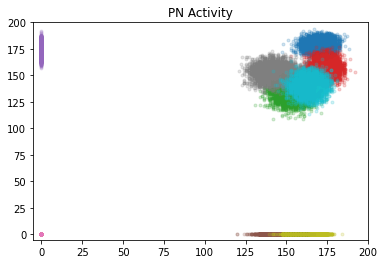

(10, 110, 19)
(10, 110, 19)
(10, 110, 19)


KeyboardInterrupt: 

In [7]:
# neuron numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)

num_inputs = 50000 # num of input points
N = 10 # num of odors
T = 5000 # num of time points

# LOOP - RUN THRU MULTIPLE ROUNDS OF TRAINING W/ SAME SET OF INPUT DISTRIBUTIONS

R = 10 # number of runs of training 
eta = 0.01 # learning rate

# removing diff numbers of KCs (1, then 5 to 110 in increments of 5)
num_removed = np.ones(23)
num_removed[1:] = np.linspace(5, 110, 22)
num_removed = num_removed.astype(int)
K = len(num_removed)

all_error_rates = np.zeros((K, R, T, num_mbons)) # array to store error rates

all_kc_weights = np.zeros((K, R, num_kcs, num_mbons)) # array to store all final KC weights for each run

all_kc_biases = np.zeros((K, R, num_kcs)) # array to store KC biases from each run
all_mbon_biases = np.zeros((K, R, num_mbons)) # array to store MBON biases from each run

time = np.full((K, R, num_mbons), T+1) # records the time step where error rates for each MBON reached 0.05 or below

input_means = np.zeros((N, num_pns))

all_kcs_removed = [[[] for _ in range(R)] for _ in range(K)] # stores the names of the KCs removed

# GENERATING ODORS
# # for running with new odors
spikes = 200
# bool_response = np.random.binomial(1, 0.5, (N, num_pns))  # .5 probability - https://journals.physiology.org/doi/full/10.1152/jn.01283.2007   
# probability = np.random.normal(0.8, 0.05, (N, num_pns)) # center, std, size
# response = np.multiply(bool_response, probability)

# # record input distributions
# input_means = response

# for rerunning with previous odors and removing based on previous weights
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control/input-means4.pkl', 'rb') as f:
    input_means = pickle.load(f)

with open('C:/Katherine/Research/experiment-data-v3/10-odors/control/final-weights4.pkl', 'rb') as f:
    prev_final_weights = pickle.load(f)

response = input_means

# target outputs for each odor - CHECK IF THERE ARE THE SAME OUTPUTS
odor_outputs = np.zeros((N, num_mbons))
# for i in range(N):
#     odor_outputs[i] = np.random.randint(0, 2, num_mbons)
odor_outputs[0] = [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]
odor_outputs[1] = [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
odor_outputs[2] = [1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
odor_outputs[3] = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]
odor_outputs[4] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
odor_outputs[5] = [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
odor_outputs[6] = [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
odor_outputs[7] = [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
odor_outputs[8] = [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
odor_outputs[9] = [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]

target_outputs = np.full((num_inputs, num_mbons), odor_outputs[0]) # array of target outputs used for training
for i in range(N):
    target_outputs[i*num_inputs//N:] = odor_outputs[i]

# LOOP THRU MULTIPLE REMOVAL EXPERIMENTS
for k in range(K):
    
    # LOOP THRU MULTIPLE REALIZATIONS OF TRAINING
    for r in range(R):
        # GENERATE INPUT DISTRIBUTIONS
        all_inputs = np.zeros((num_inputs, num_pns)) # 2D input array used for neural network
        odor_idx = num_inputs//N
        pn_inputs = np.zeros((N, num_inputs//N, num_pns)) # 3D inputs separated by odor
        for n in range(N):
            inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
            all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
            pn_inputs[n] = inputs
            
        # plot input distributions
        if r == 0:
            plt.figure()
            for i in range(N):
                plt.plot(pn_inputs[i, :, 2], pn_inputs[i, :, -3], '.', alpha = 0.2)
            plt.title("PN Activity")
            plt.xlim(-5, 200)
            plt.ylim(-5, 200)

            plt.show()
        
        # SET BIAS VALUES FOR KCS 
        kc_biases = np.zeros((num_kcs,)) # stores biases for all KCs
        pn_synapses = pn_kc.to_numpy()

        for i in range(num_kcs):
            w = pn_synapses[:, i] # get weights column by column (where columns correspond to # of synapses to each KC)
            kc_biases[i] = set_kc_bias(all_inputs, w)

        total_output1 = build_pn_to_kc(all_inputs, pn_synapses, kc_biases) # calculate all outputs of KCs for all input points
        # dimensions: inputs (15000 x 40), weights (40 x 110), biases (1 x 110) -> output (15000 x 110)

        # SET WEIGHTS
        # start with same initial set of weights
        kc_mbon_copy = kc_mbon.copy(deep=True) # weights (synapse table)
        
#         weights = kc_mbon_copy.to_numpy() # not removing any weights

        # ABLATE KCS WITH HIGH SYNAPTIC WEIGHT VALUES
#         weights, kc_names = ablate_top_kcs(prev_final_weights, kc_mbon_copy, num_removed[k], r) 
#         all_kcs_removed[k][r] = kc_names # record which KCs get ablated
#         weights = normalize_weights_np(weights, 1)

        # RANDOMLY ABLATE KCS
#         weights, kc_names = ablate_rand_kcs(kc_mbon_copy, num_removed[k])
#         all_kcs_removed[k][r] = kc_names # record which KCs' connections are randomly removed
#         weights = normalize_weights_np(weights, 1)

        # PRUNE RANDOM KCS
#         weights, kc_names = prune_rand_kcs(kc_mbon_copy, num_removed[k])
#         all_kcs_removed[k][r] = kc_names # record which KCs' connections are randomly removed
#         weights = normalize_weights_np(weights, 1)
        
        # PRUNE TOP KCS
        weights, kc_names = prune_top_kcs(prev_final_weights, kc_mbon_copy, num_removed[k], r)
        all_kcs_removed[k][r] = kc_names # record which KCs' connections are randomly removed
#         print(weights)
        weights = normalize_weights_np(weights, 1)

        # SET INITIAL VALUES
        bool_synapses = np.where(weights > 0, 1, 0) # boolean representation of the synaptic weights where an element is 1 if w > 0

        biases = np.full((num_mbons,), 0.1) # initialize all biases of MBONS at 0.1

        total_error_rate = np.zeros((T, num_mbons)) # stores percentage of correct outputs for each MBON

        # LOOP THROUGH INPUTS TO TRAIN MODEL
        for p in range(T):

            # PN -> KC (fixed weights, biases)

            # get random index of input
            index = random.randint(num_inputs)

            # using input to PN layer, get output of KC layer
            output1 = total_output1[index]

            # KC -> MBON (training portion - weights, biases are updated)
            inputs = output1 # inputs taken from output of pn->kc
            output2 = build_kc_to_mbon(inputs, weights, biases)

            # CALCULATE TOTAL ERROR FOR ALL INPUTS
            total_output2 = build_kc_to_mbon(total_output1, weights, biases) # calculate total output of MBONs
            # dimensions: inputs (15000 x 110), weights (110 x 19), biases (1 x 19) -> output (15000 x 19)

            # NOTE: each column of output array represents output of each single MBON for all the inputs
            total_error = target_outputs - total_output2
            # dimensions: target output (15000 x 19), total output MBON (15000 x 19) -> error (15000 x 19)

            total_error_rate[p, :] = 1 - np.sum((total_error == 0), axis=0) / num_inputs # store current error rates

            # record when error rate for each MBON reaches a threshold (0.05 or less)
            current_error_rate = total_error_rate[p, :] # gets current error rates for all MBONS
            met_idxs = np.asarray(np.where(current_error_rate <= 0.05)).flatten() # indicies where the error rate meets 0.05 or less
            if len(met_idxs) > 0:
                for i in range(len(met_idxs)):
                    idx = met_idxs[i]
                    current = time[k, r, idx]
                    if (current == T+1): # only if time step is not already recorded 
                        time[k, r, idx] = p # record the time step where target error rate was achieved

            # UPDATE VALUES
            error = target_outputs[index] - output2

            # update weights w/ the delta rule
            deltaw = np.outer(inputs, error) * eta # computes change in weights
            deltaw = np.multiply(deltaw, bool_synapses) # change only existing connections
            weights = weights + deltaw
            weights = normalize_weights_np(weights, 1) # normalize weights

            # update bias w/ the delta rule
            delta_bias = np.multiply(biases, error) * eta # computes change in biases
            biases = biases + delta_bias

#         print("Realization {}: DONE".format(r+1))
#         # PLOT ERROR RATES OVER TIME FOR EACH MBON
#         figure, axis = plt.subplots(7, 3, figsize=(16, 16))

#         a = 0
#         for n in range(6):
#             for m in range(3): 
#                 axis[n, m].plot(total_error_rate[:,a])
#                 axis[n, m].set_title(kc_mbon.columns[a])
#                 axis[n, m].set_ylim(-0.1, 1.1)
#                 a += 1

#         axis[6, 0].plot(total_error_rate[:,18])
#         axis[6, 0].set_title(kc_mbon.columns[18])
#         axis[6, 0].set_ylim(-0.1, 1.1)

#         plt.subplots_adjust(left=0.1,
#                             bottom=0.1, 
#                             right=0.9, 
#                             top=0.9, 
#                             wspace=0.4, 
#                             hspace=0.4)
#         plt.show()

        # STORE FINAL VALUES
        all_error_rates[k, r] = total_error_rate # add error rate over time for this run to array that holds all error rates 
        all_kc_weights[k, r] = weights # add final weight for this run to array of all final weights

        all_kc_biases[k, r] = kc_biases # stores KC biases for each run
        all_mbon_biases[k, r] = biases # stores final MBON biases for each run

    # PLOT AVERAGE ERROR RATES OVER TIME
    print("Removed {}:".format(num_removed[k]))
    avg_error_rates = np.mean(all_error_rates[k], axis=0)
    std_error_rates = np.std(all_error_rates[k], axis=0)

    x = np.linspace(0, 5000, 5000)

    figure, axis = plt.subplots(7, 3, figsize=(16, 24))

    a = 0 
    for n in range(7):
        for m in range(3):
            if a < 19:
                axis[n, m].set_title(kc_mbon.columns[a], fontsize=20)
                axis[n, m].set_ylim(-0.1, 1.1)

                axis[n, m].plot(avg_error_rates[:,a], color='blue', linewidth=1, label='Average') # plots average error rate
                axis[n, m].fill_between(x, avg_error_rates[:,a] - std_error_rates[:,a], avg_error_rates[:,a] + std_error_rates[:,a], alpha=0.5, facecolor='red', label='Standard Deviation')
                axis[n, m].tick_params(axis='x', labelsize=12)
                axis[n, m].tick_params(axis='y', labelsize=12)

            a += 1
#     axis[2, 1].legend(fontsize=15)

    plt.subplots_adjust(left=0.1,
                        bottom=0/.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()


In [71]:
# SAVE DATA
# save final set of weights for each run
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/final-weights9.pkl', 'wb') as f:
    pickle.dump(all_kc_weights, f)

# save final set of KC biases for each run
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/final-kc-biases9.pkl', 'wb') as f:
    pickle.dump(all_kc_biases, f)

# save final set of MBON biases for each run
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/final-mbon-biases9.pkl', 'wb') as f:
    pickle.dump(all_mbon_biases, f)

# save error rates over time
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/all-error-rates9.pkl', 'wb') as f:
    pickle.dump(all_error_rates, f)
    
# save time for each MBON to learn
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/target-met-time9.pkl', 'wb') as f:
    pickle.dump(time, f)
    
# # save odor means
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/input-means9.pkl', 'wb') as f:
    pickle.dump(input_means, f)
    
# save input distributions
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/3-odors/targeted-ablation/input3.pkl', 'wb') as f:
#     pickle.dump(total_inputs, f)
    
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/3-odors/targeted-ablation/inputs-3D3.pkl', 'wb') as f:
#     pickle.dump(total_inputs_3D, f)
    
# save the names of KCs that were removed
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning/kcs-removed9.pkl', 'wb') as f:
    pickle.dump(all_kcs_removed, f)

(19,)


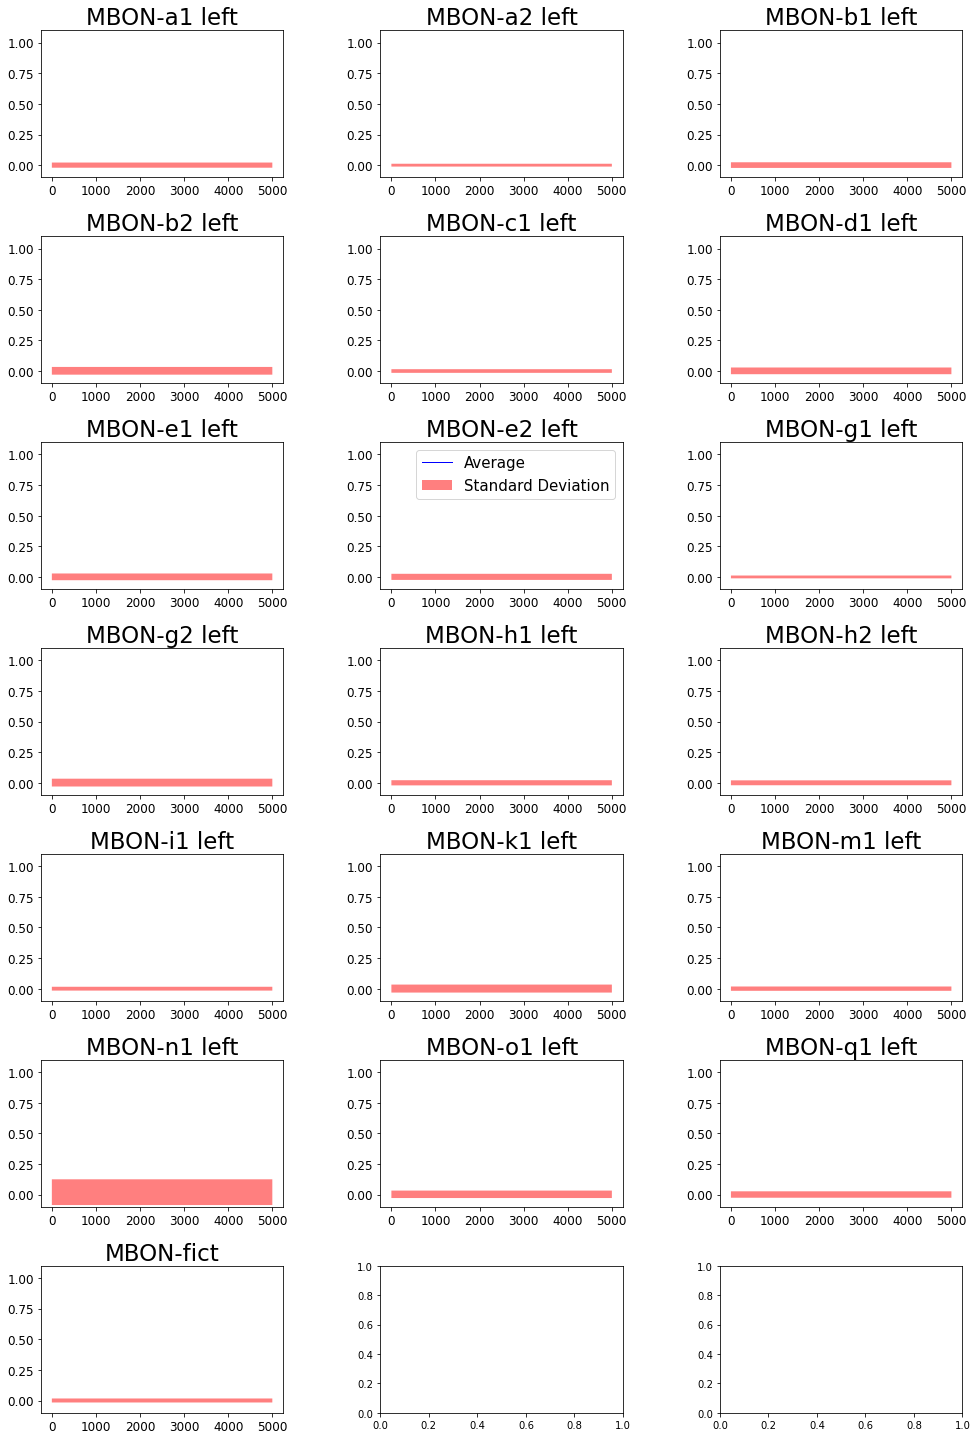

In [22]:
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

avg_error = np.mean(error_rate_over_time[0], axis=0)
print(avg_error.shape)

std_error = np.std(error_rate_over_time[0], axis=0)

x = np.linspace(0, 5000, 5000)
    
# PLOT AVERAGE ERROR RATES OVER TIME
figure, axis = plt.subplots(7, 3, figsize=(16, 24))

a = 0 
for n in range(7):
    for m in range(3):
        if a < 19:
            axis[n, m].set_title(kc_mbon.columns[a], fontsize=23)
            axis[n, m].set_ylim(-0.1, 1.1)

    #         for p in range(10):
    #             axis[n, m].plot(error_rate_over_time[p,:,a], color='red', alpha=0.2) # plot error rate lines from all 10 runs

            axis[n, m].plot(avg_error[a], color='blue', linewidth=1, label='Average') # plots average error rate
            axis[n, m].fill_between(x, avg_error[a] - std_error[a], avg_error[a] + std_error[a], alpha=0.5, facecolor='red', label='Standard Deviation')
            axis[n, m].tick_params(axis='x', labelsize=12)
            axis[n, m].tick_params(axis='y', labelsize=12)
        
        a += 1
axis[2, 1].legend(fontsize=15)
        
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

<IPython.core.display.Javascript object>


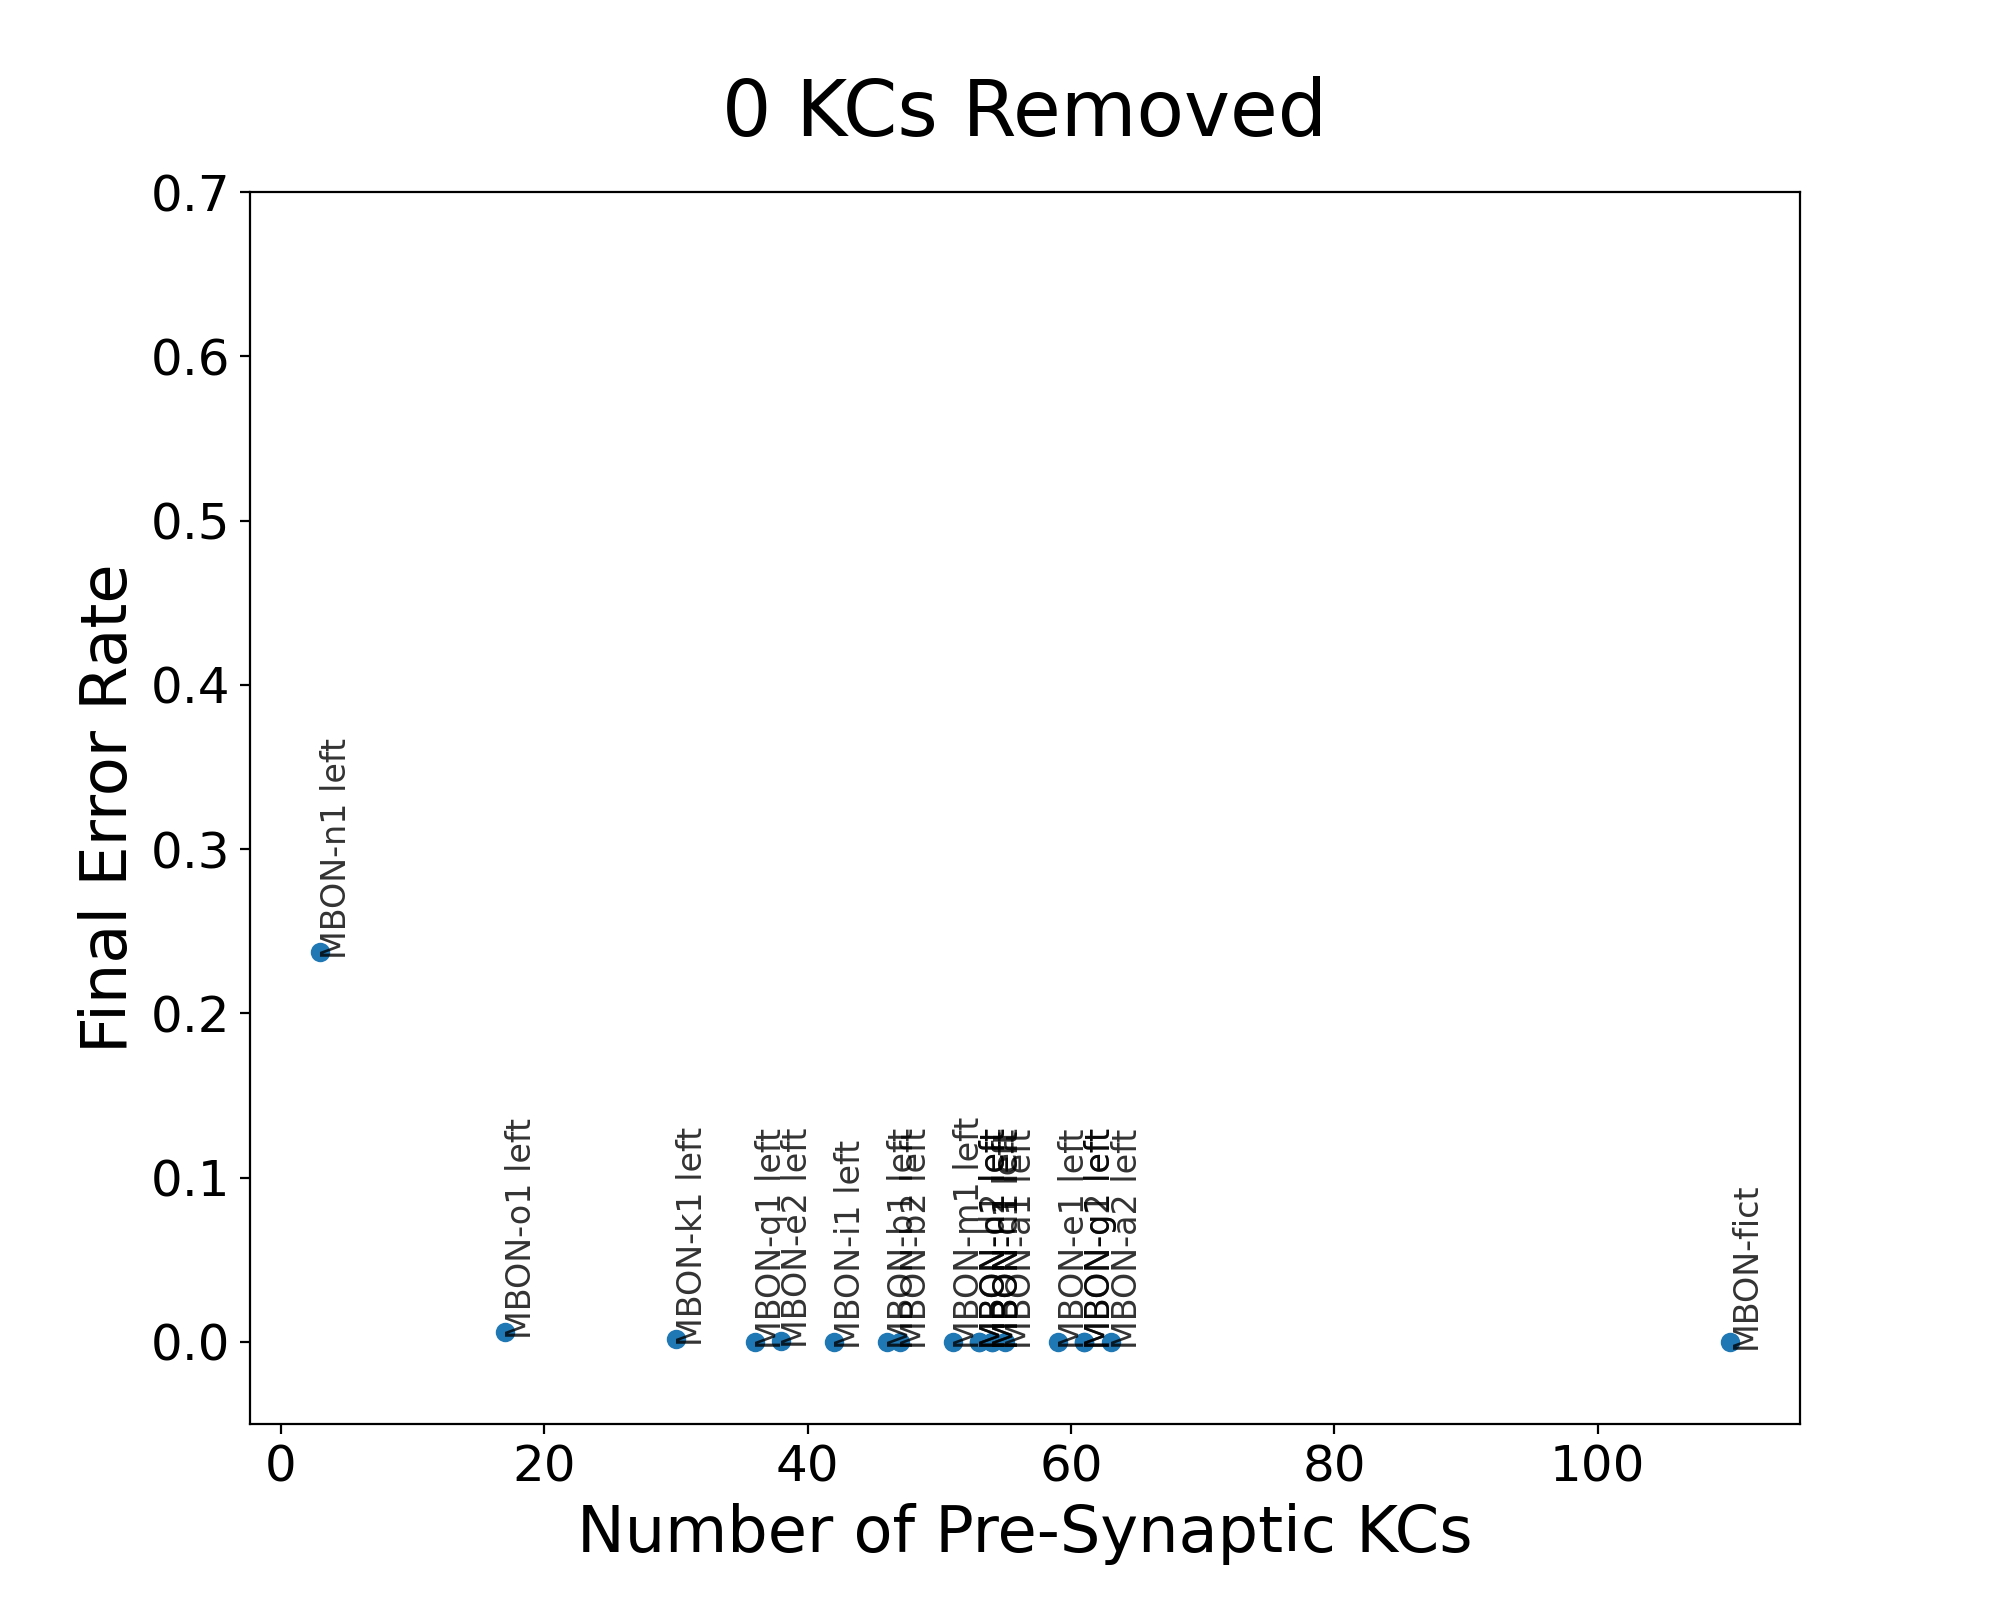

In [202]:
# PLOT NUMBER OF KC CONNECTIONS VS. AVG FINAL ERROR RATE

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/final-weights18.pkl', 'rb') as f:
    final_weights = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/all-error-rates18.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)

N = 0 # number of KCs removed

avg_error = np.mean(error_rate_over_time, axis=0)

bool_conn = np.where(kc_mbon > 0, 1, 0)
sums = bool_conn.sum(axis=0)
# print(sums)
temp = np.where(sums - N < 0, 0, sums)
# print(temp)

plt.figure(figsize=(10,8))

x = np.subtract(temp, N, where=temp>0) # number of synapses
# print(x)
y = avg_error[-1,0:19] # final error rate

plt.plot(x, y, 'o')

# m, b = np.polyfit(x, y, 1)
# plt.plot(x, m*x + b, alpha=0.3)

# plt.title("Number of KC Connections vs. Average Final Error Rate (Ablate Top {} KCs)".format(N))
plt.title("0 KCs Removed", fontsize=28, pad=20)
plt.xlabel("Number of Pre-Synaptic KCs", fontsize=23)
plt.ylabel("Final Error Rate", fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.7)

# label MBONs
names = kc_mbon.columns

for i, label in enumerate(names):
    plt.text(x[i], y[i], label, fontdict=dict(color='black', alpha=0.8, size=12, fontfamily='sans-serif'), rotation='vertical')


plt.show()

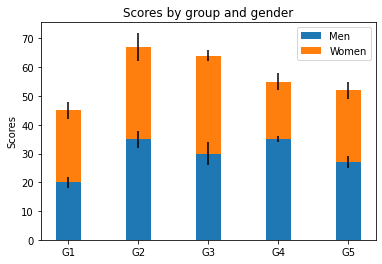

In [38]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 35, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, width, yerr=men_std, label='Men')
ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
       label='Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()


[[17, 11, 14, 17, 7, 4, 5], [17, 9, 10, 11, 3, 0, 0], [17, 5, 5, 2, 1, 0, 0], [14, 4, 2, 0, 0, 0, 0], [7, 1, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


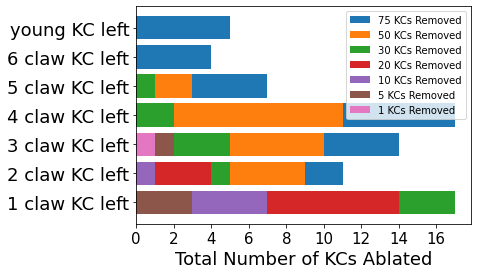

[[17, 11, 14, 18, 7, 4, 4], [17, 9, 10, 12, 2, 0, 0], [17, 7, 4, 2, 0, 0, 0], [11, 6, 3, 0, 0, 0, 0], [6, 2, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


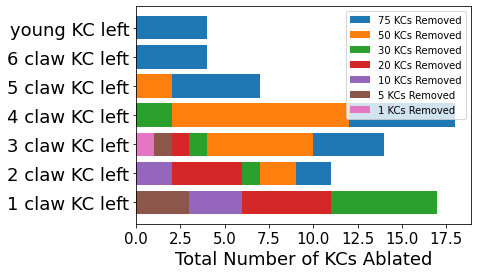

[[17, 11, 14, 18, 7, 4, 4], [17, 9, 10, 11, 3, 0, 0], [16, 6, 5, 3, 0, 0, 0], [13, 5, 2, 0, 0, 0, 0], [6, 2, 2, 0, 0, 0, 0], [2, 1, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


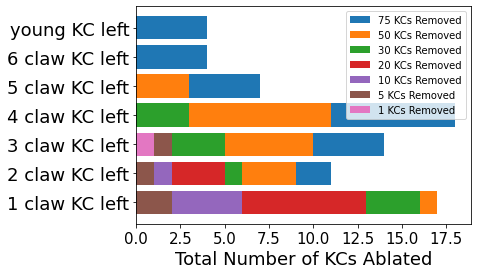

[[17, 11, 14, 18, 7, 4, 4], [17, 9, 9, 12, 3, 0, 0], [17, 6, 4, 3, 0, 0, 0], [14, 4, 2, 0, 0, 0, 0], [6, 2, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


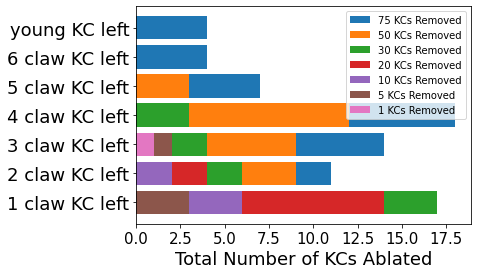

[[17, 11, 14, 18, 8, 4, 3], [17, 9, 9, 12, 3, 0, 0], [17, 6, 5, 2, 0, 0, 0], [14, 4, 2, 0, 0, 0, 0], [8, 0, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


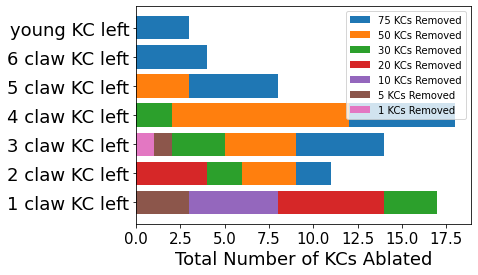

[[17, 11, 14, 18, 7, 5, 3], [17, 9, 9, 12, 3, 0, 0], [17, 6, 5, 2, 0, 0, 0], [12, 6, 2, 0, 0, 0, 0], [7, 1, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


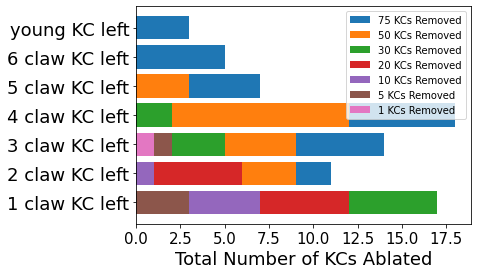

[[17, 11, 14, 18, 8, 4, 3], [17, 9, 9, 12, 3, 0, 0], [16, 7, 5, 2, 0, 0, 0], [12, 5, 3, 0, 0, 0, 0], [5, 3, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


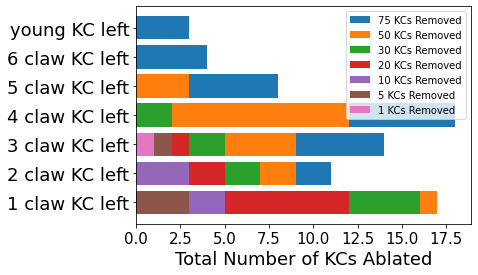

[[17, 11, 13, 17, 7, 4, 6], [17, 9, 9, 12, 3, 0, 0], [17, 6, 5, 2, 0, 0, 0], [12, 5, 2, 1, 0, 0, 0], [7, 1, 2, 0, 0, 0, 0], [2, 1, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


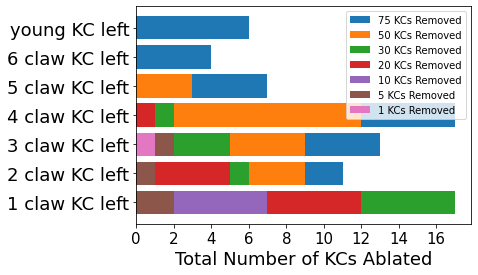

[[17, 11, 14, 18, 7, 4, 4], [17, 9, 9, 12, 3, 0, 0], [17, 6, 4, 2, 1, 0, 0], [13, 5, 2, 0, 0, 0, 0], [7, 1, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


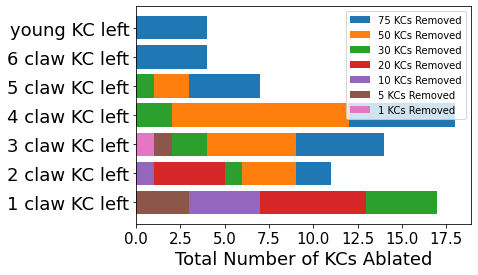

[[17, 11, 14, 18, 8, 4, 3], [17, 8, 10, 12, 3, 0, 0], [17, 6, 5, 2, 0, 0, 0], [13, 5, 2, 0, 0, 0, 0], [5, 3, 2, 0, 0, 0, 0], [3, 0, 2, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]]


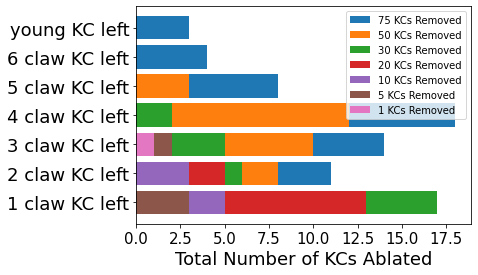

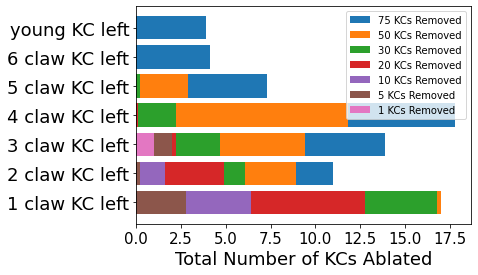

In [74]:
# counts number of occurrences of a string in a 2d list
def countX(lst, x):
    count = 0
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if (lst[i][j] == x):
                count = count + 1
    return count

# BAR GRAPH OF TYPE OF KC REMOVED (5 removed)
names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', '6 claw KC left', 'young KC left']
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/kcs-removed5.pkl', 'rb') as f:
    kc_names = pickle.load(f)

for j in range(10):
    plt.figure()
    num_real = j # realization to get KC names from

    # nums = [100, 75, 50, 25, 5, 1] # numbers of KCs removed
    # nums_idx = [20, 15, 10, 5, 1, 0] # indicies for each number of KCs removed

    nums = [75, 50, 30, 20, 10, 5, 1] # numbers of KCs removed
    nums_idx = [15, 10, 6, 4, 2, 1, 0] # indicies for each number of KCs removed
    rows, cols = (5, 7)
    counts = [] # nums by counts of names of KCs 
    for n in range(len(nums)):
        names_list = kc_names[nums_idx[n]][num_real]
        col = []
        for c in range(cols):
            col.append(names_list.count(names[c]))
        counts.append(col)
    print(counts)

    for i in range(len(nums)):
        label = "{} KCs Removed".format(nums[i])
        if i > 0:
            plt.barh(names, counts[i], label=label)
        else:
            plt.barh(names, counts[i], label=label)

    plt.xlabel("Total Number of KCs Ablated", fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=18, rotation=0)

    plt.legend(fontsize=10)
    plt.show()
    

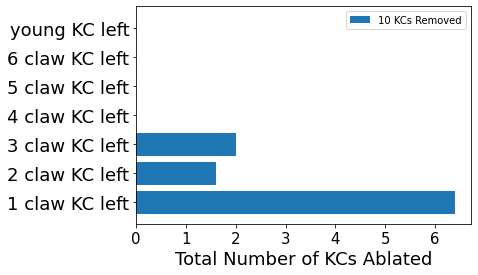

In [77]:
plt.figure()
nums = [10] # numbers of KCs removed
nums_idx = [2] # indicies for each number of KCs removed
rows, cols = (5, 7)
counts = [] # nums by counts of names of KCs 
for j in range(10):
    b = []
    for n in range(len(nums)):
        names_list = kc_names[nums_idx[n]][j]
        col = []
        for c in range(cols):
            col.append(names_list.count(names[c]))
        b.append(col)
    counts.append(b)
arr = np.asarray(counts)
counts_avg = np.mean(arr, axis=0)

for i in range(len(nums)):
    label = "{} KCs Removed".format(nums[i])
    if i > 0:
        plt.barh(names, counts_avg[i], label=label)
    else:
        plt.barh(names, counts_avg[i], label=label)

plt.xlabel("Total Number of KCs Ablated", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18, rotation=0)

plt.legend(fontsize=10)
plt.show()

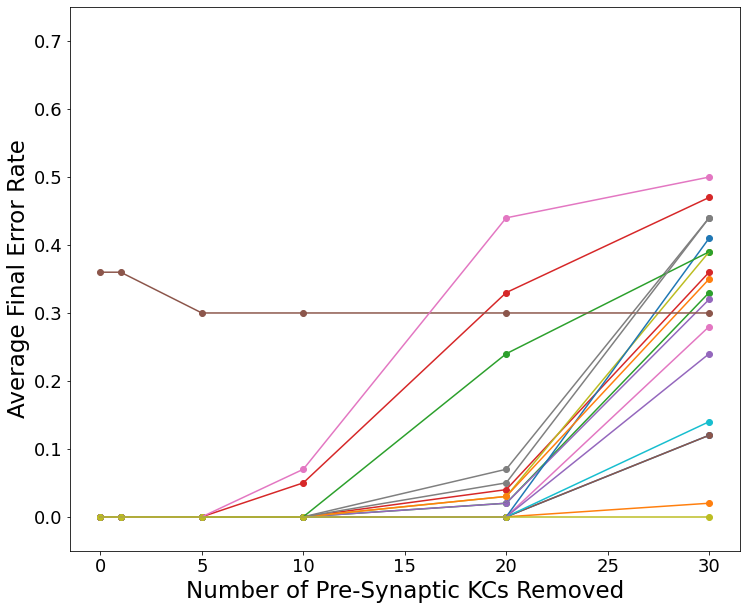

In [19]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
#     final_weights0 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
#     error_over_time0 = pickle.load(f)
# # 1 KC removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/final-weights37.pkl', 'rb') as f:
#     final_weights1 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/all-error-rates37.pkl', 'rb') as f:
#     error_over_time1 = pickle.load(f)
# # 5 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/final-weights38.pkl', 'rb') as f:
#     final_weights5 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/all-error-rates38.pkl', 'rb') as f:
#     error_over_time5 = pickle.load(f)
# # 10 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/final-weights39.pkl', 'rb') as f:
#     final_weights10 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/all-error-rates39.pkl', 'rb') as f:
#     error_over_time10 = pickle.load(f)
# # 20 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/final-weights40.pkl', 'rb') as f:
#     final_weights20 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/all-error-rates40.pkl', 'rb') as f:
#     error_over_time20 = pickle.load(f)
# # 30 KCs removed    
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/final-weights41.pkl', 'rb') as f:
#     final_weights30 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/all-error-rates41.pkl', 'rb') as f:
#     error_over_time30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/10-odors/targeted-ablation/all-error-rates6.pkl', 'rb') as f:
    error_over_time = pickle.load(f)
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_control = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
        
for i in range(num_mbons):
    for j in range(6):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error1 = np.mean(error_over_time[0], axis=0)
avg_error5 = np.mean(error_over_time[1], axis=0)
avg_error10 = np.mean(error_over_time[2], axis=0)
avg_error20 = np.mean(error_over_time[3], axis=0)
avg_error30 = np.mean(error_over_time[4], axis=0)

y = []
# add each MBONs' error rates for different number of KCs removed
for k in range(num_mbons):
    y.append(avg_error0[-1,k])
    y.append(avg_error1[-1,k])
    y.append(avg_error5[-1,k])
    y.append(avg_error10[-1,k])
    y.append(avg_error20[-1,k])
    y.append(avg_error30[-1,k])

# plot points with lines
for p in range(num_mbons):
    start = p * 6
    end = (p * 6) + 6
    plt.scatter(x[start:end], y[start:end])
    plt.plot(x[start:end], y[start:end])

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=23)
plt.ylabel("Average Final Error Rate", fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.75)
plt.show()

(23, 10, 5000, 19)


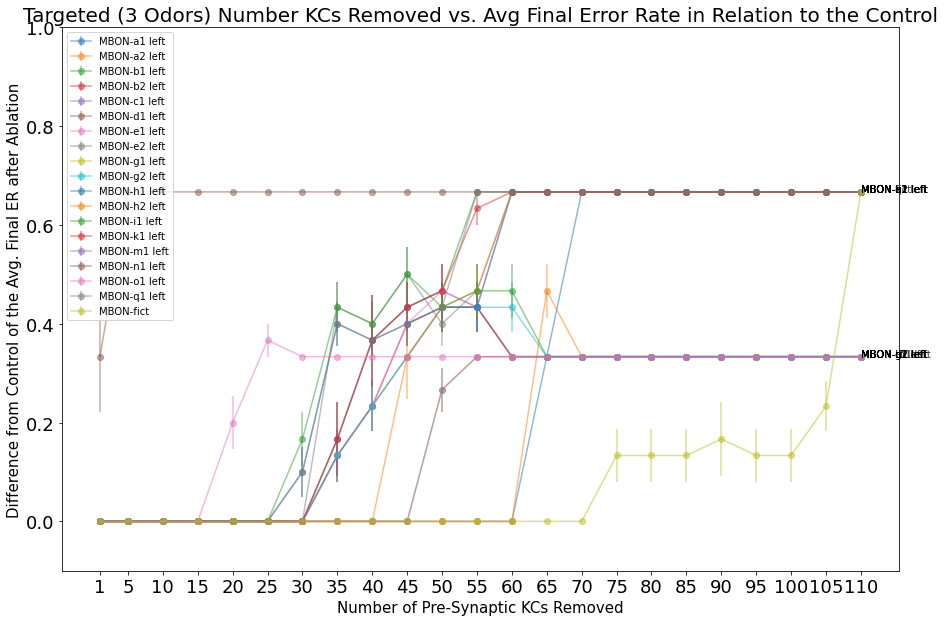

In [16]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS
num_mbons = 19
K = 23
T = 5000

# import data
# 0 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
#     final_weights0 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
#     error_over_time0 = pickle.load(f)
# # 1 KC removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/final-weights37.pkl', 'rb') as f:
#     final_weights1 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/all-error-rates37.pkl', 'rb') as f:
#     error_over_time1 = pickle.load(f)
# # 5 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/final-weights38.pkl', 'rb') as f:
#     final_weights5 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run38-top5-w1-odor3/all-error-rates38.pkl', 'rb') as f:
#     error_over_time5 = pickle.load(f)
# # 10 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/final-weights39.pkl', 'rb') as f:
#     final_weights10 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run39-top10-w1-odor3/all-error-rates39.pkl', 'rb') as f:
#     error_over_time10 = pickle.load(f)
# # 20 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/final-weights40.pkl', 'rb') as f:
#     final_weights20 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run40-top20-w1-odor3/all-error-rates40.pkl', 'rb') as f:
#     error_over_time20 = pickle.load(f)
# # 30 KCs removed    
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/final-weights41.pkl', 'rb') as f:
#     final_weights30 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run41-top30-w1-odor3/all-error-rates41.pkl', 'rb') as f:
#     error_over_time30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/targeted-ablation/all-error-rates2.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

print(error_over_time.shape)
plt.figure(figsize=(15, 10))
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []
        
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference from Control of the Avg. Final ER after Ablation", fontsize=15)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.title("Targeted (3 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
plt.legend()
plt.show()

In [53]:
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/targeted-ablation/all-error-rates2.pkl', 'rb') as f:
#     error_over_time = pickle.load(f)
    
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/all-error-rates1.pkl', 'rb') as f:
#     error_control = pickle.load(f)
    
# print(error_over_time.shape) # K, R, T, num_mbons
# print(error_control.shape) # R, T, num_mbons

# print(np.mean(error_control, axis=0).shape) # T, num_mbons
# print(np.mean(error_over_time[0], axis=0).shape) # T, num_mbons

437
437


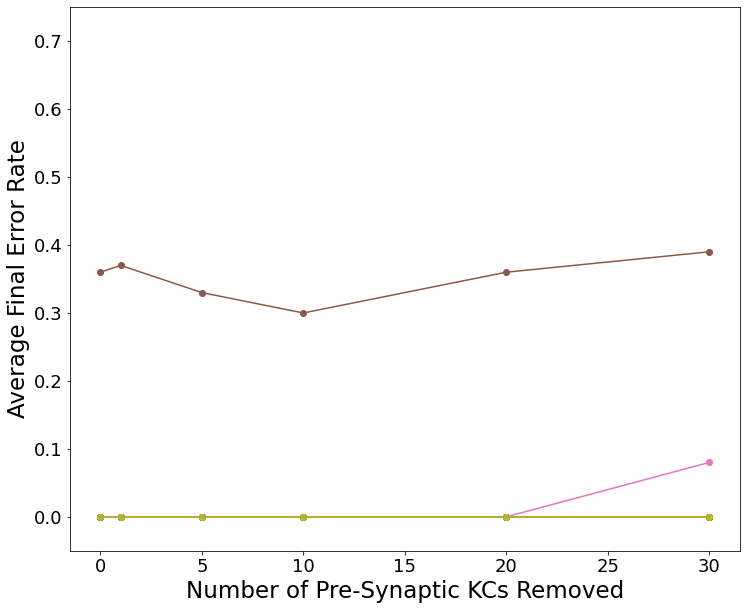

In [23]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE - RANDOM ABLATION

# import data
# 0 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
#     final_weights0 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
#     error_over_time0 = pickle.load(f)
# # 1 KC removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/final-weights42.pkl', 'rb') as f:
#     final_weights1 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/all-error-rates42.pkl', 'rb') as f:
#     error_over_time1 = pickle.load(f)
# # 5 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/final-weights43.pkl', 'rb') as f:
#     final_weights5 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/all-error-rates43.pkl', 'rb') as f:
#     error_over_time5 = pickle.load(f)
# # 10 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/final-weights44.pkl', 'rb') as f:
#     final_weights10 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/all-error-rates44.pkl', 'rb') as f:
#     error_over_time10 = pickle.load(f)
# # 20 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/final-weights45.pkl', 'rb') as f:
#     final_weights20 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/all-error-rates45.pkl', 'rb') as f:
#     error_over_time20 = pickle.load(f)
# # 30 KCs removed    
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/final-weights46.pkl', 'rb') as f:
#     final_weights30 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/all-error-rates46.pkl', 'rb') as f:
#     error_over_time30 = pickle.load(f)
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/random-ablation/all-error-rates5.pkl', 'rb') as f:
    error_over_time = pickle.load(f)
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_control = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
        
for i in range(num_mbons):
    for j in range(6):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error1 = np.mean(error_over_time[0], axis=0)
avg_error5 = np.mean(error_over_time[1], axis=0)
avg_error10 = np.mean(error_over_time[2], axis=0)
avg_error20 = np.mean(error_over_time[3], axis=0)
avg_error30 = np.mean(error_over_time[4], axis=0)

y = []
# add error rates for each MBON
for k in range(num_mbons):
    y.append(avg_error0[-1,k])
    y.append(avg_error1[-1,k])
    y.append(avg_error5[-1,k])
    y.append(avg_error10[-1,k])
    y.append(avg_error20[-1,k])
    y.append(avg_error30[-1,k])

# plot with points and lines
for p in range(num_mbons):
    start = p * 6
    end = (p * 6) + 6
    plt.scatter(x[start:end], y[start:end])
    plt.plot(x[start:end], y[start:end])

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=23)
plt.ylabel("Average Final Error Rate", fontsize=23)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 0.75)
plt.show()

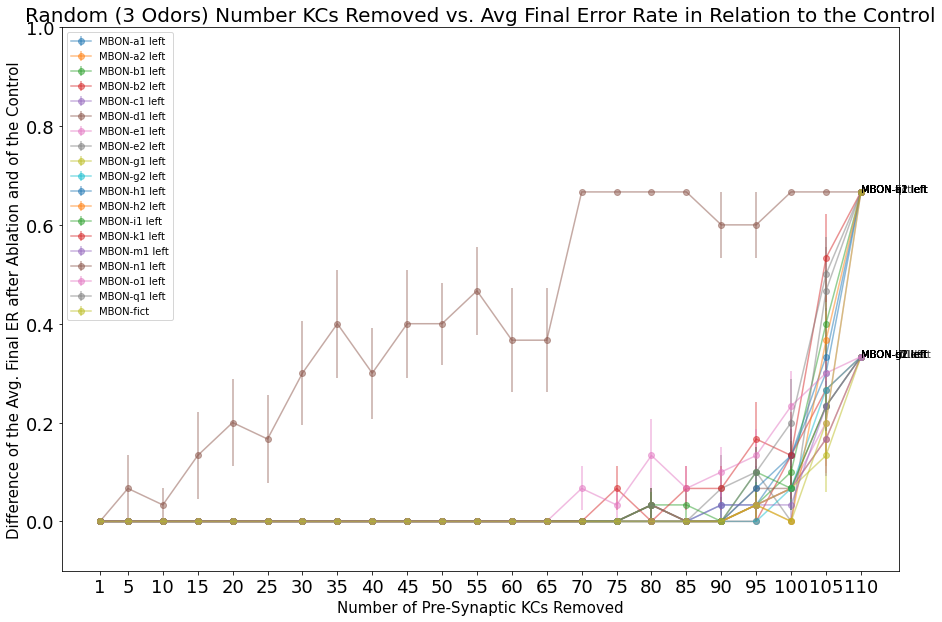

In [11]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - RANDOM ABLATION

# import data
# 0 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/final-weights36.pkl', 'rb') as f:
#     final_weights0 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run36-r0-w1-sameodorsrun12/all-error-rates36.pkl', 'rb') as f:
#     error_over_time0 = pickle.load(f)
# # 1 KC removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/final-weights42.pkl', 'rb') as f:
#     final_weights1 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run42-rand1-w1-odor3/all-error-rates42.pkl', 'rb') as f:
#     error_over_time1 = pickle.load(f)
# # 5 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/final-weights43.pkl', 'rb') as f:
#     final_weights5 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run43-rand5-w1-odor3/all-error-rates43.pkl', 'rb') as f:
#     error_over_time5 = pickle.load(f)
# # 10 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/final-weights44.pkl', 'rb') as f:
#     final_weights10 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run44-rand10-w1-odor3/all-error-rates44.pkl', 'rb') as f:
#     error_over_time10 = pickle.load(f)
# # 20 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/final-weights45.pkl', 'rb') as f:
#     final_weights20 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run45-rand20-w1-odor3/all-error-rates45.pkl', 'rb') as f:
#     error_over_time20 = pickle.load(f)
# # 30 KCs removed    
# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/final-weights46.pkl', 'rb') as f:
#     final_weights30 = pickle.load(f)

# with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run46-rand30-w1-odor3/all-error-rates46.pkl', 'rb') as f:
#     error_over_time30 = pickle.load(f)
     
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/random-ablation/all-error-rates3.pkl', 'rb') as f:
    error_over_time = pickle.load(f)
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f)
    
plt.figure(figsize=(15, 10))
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []
        
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
# print(error_over_time[0, :, -1, :].shape)
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference of the Avg. Final ER after Ablation and of the Control", fontsize=15)
plt.title("Random (3 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.legend()
plt.show()

In [75]:
# standard errors in error rate of poor performing MBONs
print("MBON-o1 left")
print(st.sem(error_over_time[4,:,-1,16]))

print("MBON-k1 left")
print(st.sem(error_over_time[4,:,-1,13]))

print("MBON-n1 left")
print(st.sem(error_over_time[4,:,-1,15]))

MBON-o1 left
0.0
MBON-k1 left
0.0
MBON-n1 left
0.0888888888888889


In [218]:
# standard errors in error rate of poor performing MBONs
print("MBON-o1 left")
print(st.sem(error_over_time30[:,-1,16]))

print("MBON-k1 left")
print(st.sem(error_over_time30[:,-1,13]))

MBON-o1 left
0.0737027731190089
MBON-k1 left
0.07114582486036498


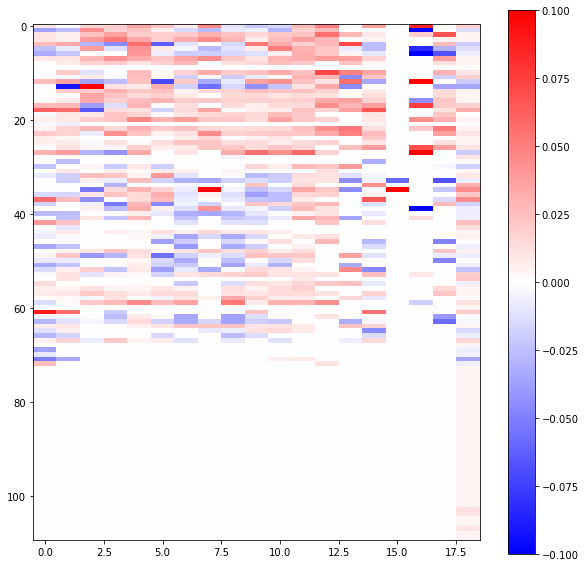

In [118]:
with open('C:/Users/Katherine Xie/RiseProject/removal-experiment-rerun2/run37-top1-w1-odor3/final-weights37.pkl', 'rb') as f:
    final_weights = pickle.load(f)
    
# HEATMAP OF WEIGHTS SUM 2 
plt.figure(figsize=(10,10))
c1 = plt.imshow(final_weights[0], cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c1)
plt.show()

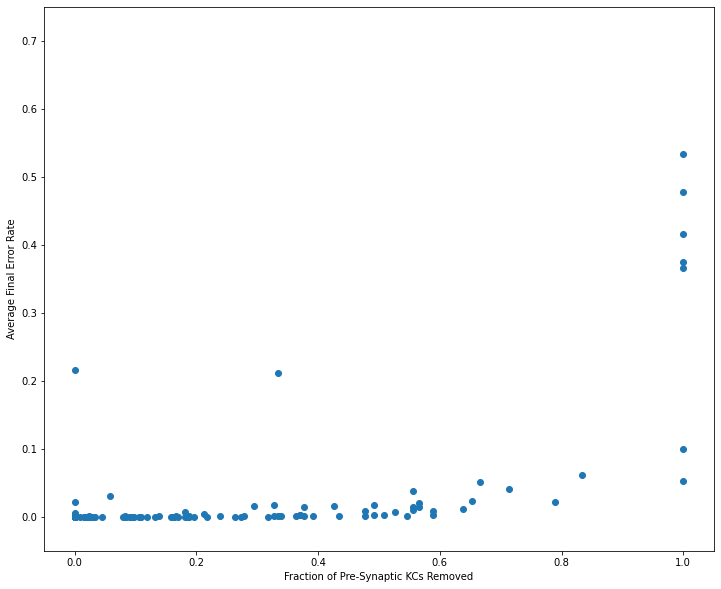

In [117]:
# FRACTION OF KCS REMOVED VS. FINAL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/all-error-rates18.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/run13-ablatetop1KC-weightsum2/final-weights13.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run13-ablatetop1KC-weightsum2/all-error-rates13.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run14-ablatetop5KC-weightsum2/final-weights14.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run14-ablatetop5KC-weightsum2/all-error-rates14.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run15-ablatetop10KC-weightsum2/final-weights15.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run15-ablatetop10KC-weightsum2/all-error-rates15.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run16-ablatetop20KC-weightsum2/final-weights16.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run16-ablatetop20KC-weightsum2/all-error-rates16.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/run17-ablatetop30KC-weightsum2/final-weights17.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run17-ablatetop30KC-weightsum2/all-error-rates17.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
for i in range(6):
    for j in range(num_mbons):
        x.append(numbers[i]) 

# print(x)      
# calculate fraction of kcs removed
bool_conn = np.where(kc_mbon > 0, 1, 0)
num_pre_kcs = bool_conn.sum(axis=0) # number of KCs originally

for i in range(6):
    start = i * num_mbons
    end = start + num_mbons
    arr = x[start:end]
    x[start:end] = np.divide(arr, num_pre_kcs)

x = np.array(x)
x = np.where(x > 1, 1, x)

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add error rates for each number of KCs removed across all MBONS to y
y.extend(avg_error0[-1,0:19])
y.extend(avg_error1[-1,0:19])
y.extend(avg_error5[-1,0:19])
y.extend(avg_error10[-1,0:19])
y.extend(avg_error20[-1,0:19])
y.extend(avg_error30[-1,0:19])

plt.plot(x, y, 'o')

plt.xlabel("Fraction of Pre-Synaptic KCs Removed")
plt.ylabel("Average Final Error Rate")
plt.ylim(-0.05, 0.75)
plt.show()

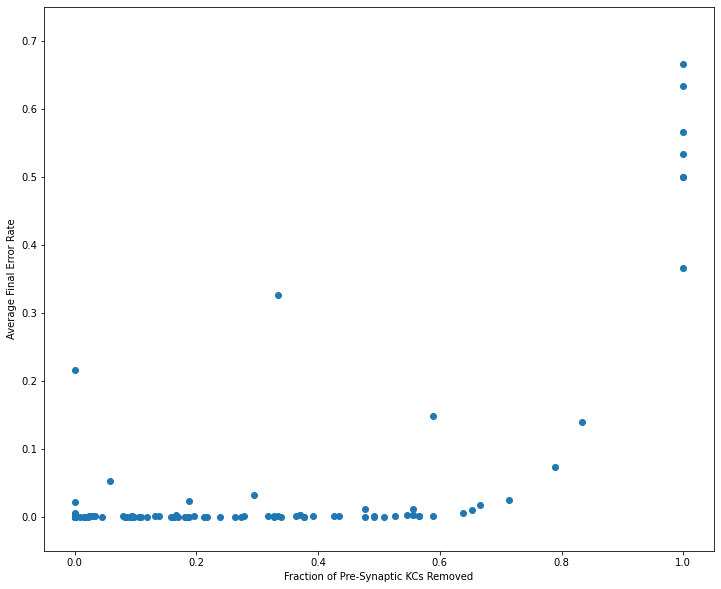

In [118]:
# FRACTION OF KCS REMOVED VS. FINAL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum2/all-error-rates18.pkl', 'rb') as f:
    error_over_time0 = pickle.load(f)
# 1 KC removed
with open('C:/Users/Katherine Xie/RiseProject/run19-randremove1KC-weightsum2/final-weights19.pkl', 'rb') as f:
    final_weights1 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run19-randremove1KC-weightsum2/all-error-rates19.pkl', 'rb') as f:
    error_over_time1 = pickle.load(f)
# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run20-randremove5KC-weightsum2/final-weights20.pkl', 'rb') as f:
    final_weights5 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run20-randremove5KC-weightsum2/all-error-rates20.pkl', 'rb') as f:
    error_over_time5 = pickle.load(f)
# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run21-randremove10KC-weightsum2/final-weights21.pkl', 'rb') as f:
    final_weights10 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run21-randremove10KC-weightsum2/all-error-rates21.pkl', 'rb') as f:
    error_over_time10 = pickle.load(f)
# 20 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run22-randremove20KC-weightsum2/final-weights22.pkl', 'rb') as f:
    final_weights20 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run22-randremove20KC-weightsum2/all-error-rates22.pkl', 'rb') as f:
    error_over_time20 = pickle.load(f)
# 30 KCs removed    
with open('C:/Users/Katherine Xie/RiseProject/run23-randremove30KC-weightsum2/final-weights23.pkl', 'rb') as f:
    final_weights30 = pickle.load(f)

with open('C:/Users/Katherine Xie/RiseProject/run23-randremove30KC-weightsum2/all-error-rates23.pkl', 'rb') as f:
    error_over_time30 = pickle.load(f)
     
plt.figure(figsize=(12, 10))
# x-axis -> number of KCs removed
numbers = [0, 1, 5, 10, 20, 30] # numbers of KCs removed
x = []
for i in range(6):
    for j in range(num_mbons):
        x.append(numbers[i]) 

# print(x)      
# calculate fraction of kcs removed
bool_conn = np.where(kc_mbon > 0, 1, 0)
num_pre_kcs = bool_conn.sum(axis=0) # number of KCs originally

for i in range(6):
    start = i * num_mbons
    end = start + num_mbons
    arr = x[start:end]
    x[start:end] = np.divide(arr, num_pre_kcs)

x = np.array(x)
x = np.where(x > 1, 1, x)

# y-axis - avg final error rate
avg_error0 = np.mean(error_over_time0, axis=0)
avg_error1 = np.mean(error_over_time1, axis=0)
avg_error5 = np.mean(error_over_time5, axis=0)
avg_error10 = np.mean(error_over_time10, axis=0)
avg_error20 = np.mean(error_over_time20, axis=0)
avg_error30 = np.mean(error_over_time30, axis=0)

y = []
# add error rates for each number of KCs removed across all MBONS to y
y.extend(avg_error0[-1,0:19])
y.extend(avg_error1[-1,0:19])
y.extend(avg_error5[-1,0:19])
y.extend(avg_error10[-1,0:19])
y.extend(avg_error20[-1,0:19])
y.extend(avg_error30[-1,0:19])

plt.plot(x, y, 'o')

plt.xlabel("Fraction of Pre-Synaptic KCs Removed")
plt.ylabel("Average Final Error Rate")
plt.ylim(-0.05, 0.75)
plt.show()

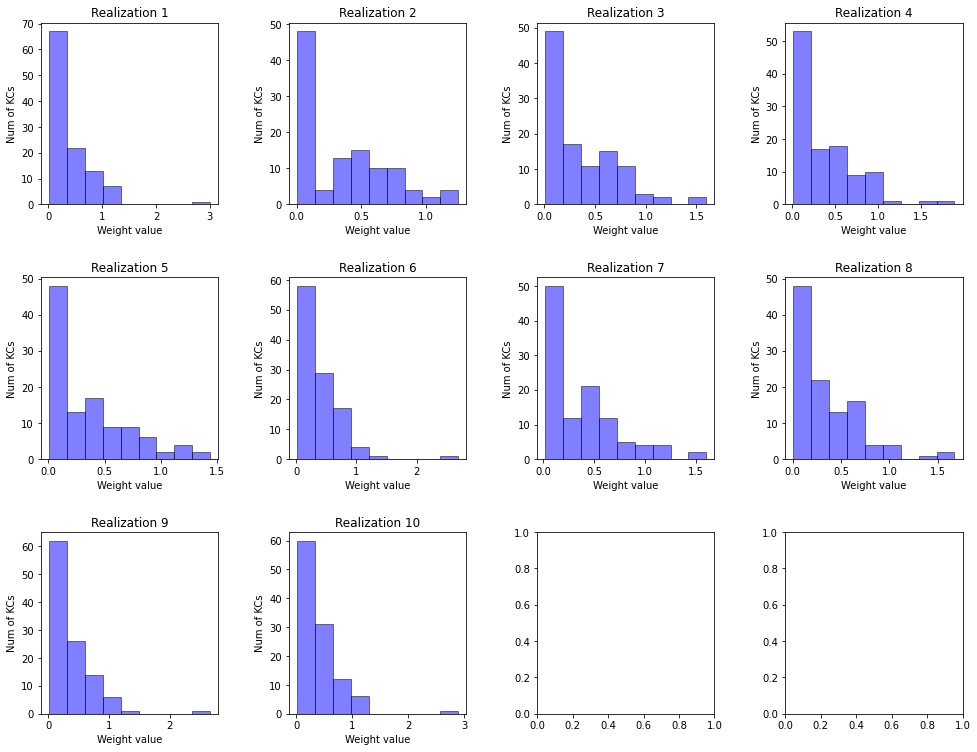

In [8]:
with open('C:/Users/Katherine Xie/RiseProject/run12-remove0KC-wsum2-savedodors/final-weights12.pkl', 'rb') as f:
    all_final_weights = pickle.load(f)
    
# find total weights from 10 sets of final weights
total_weights = np.zeros((10, 110))

for i in range(10):
    total_weights[i] = (abs(all_final_weights[i])).sum(axis=1)

# DISTRIBUTIONS OF SUM OF THE ABSOLUTE VALUE OF KC WEIGHTS FOR EACH REALIZATION
figure, axis = plt.subplots(3, 4, figsize=(16,12))

a = 0
for i in range(3):
    for j in range(4):
        if a < 10:
            # initial weights
            x = total_weights[a]
            axis[i, j].hist(x, bins=np.linspace(x.min(), x.max(), 10), edgecolor='black', color='blue', alpha=0.5)

            axis[i, j].set_title("Realization {}".format(a+1))
            axis[i, j].set_xlabel("Weight value")
            axis[i, j].set_ylabel("Num of KCs")
        
        a += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

<IPython.core.display.Javascript object>


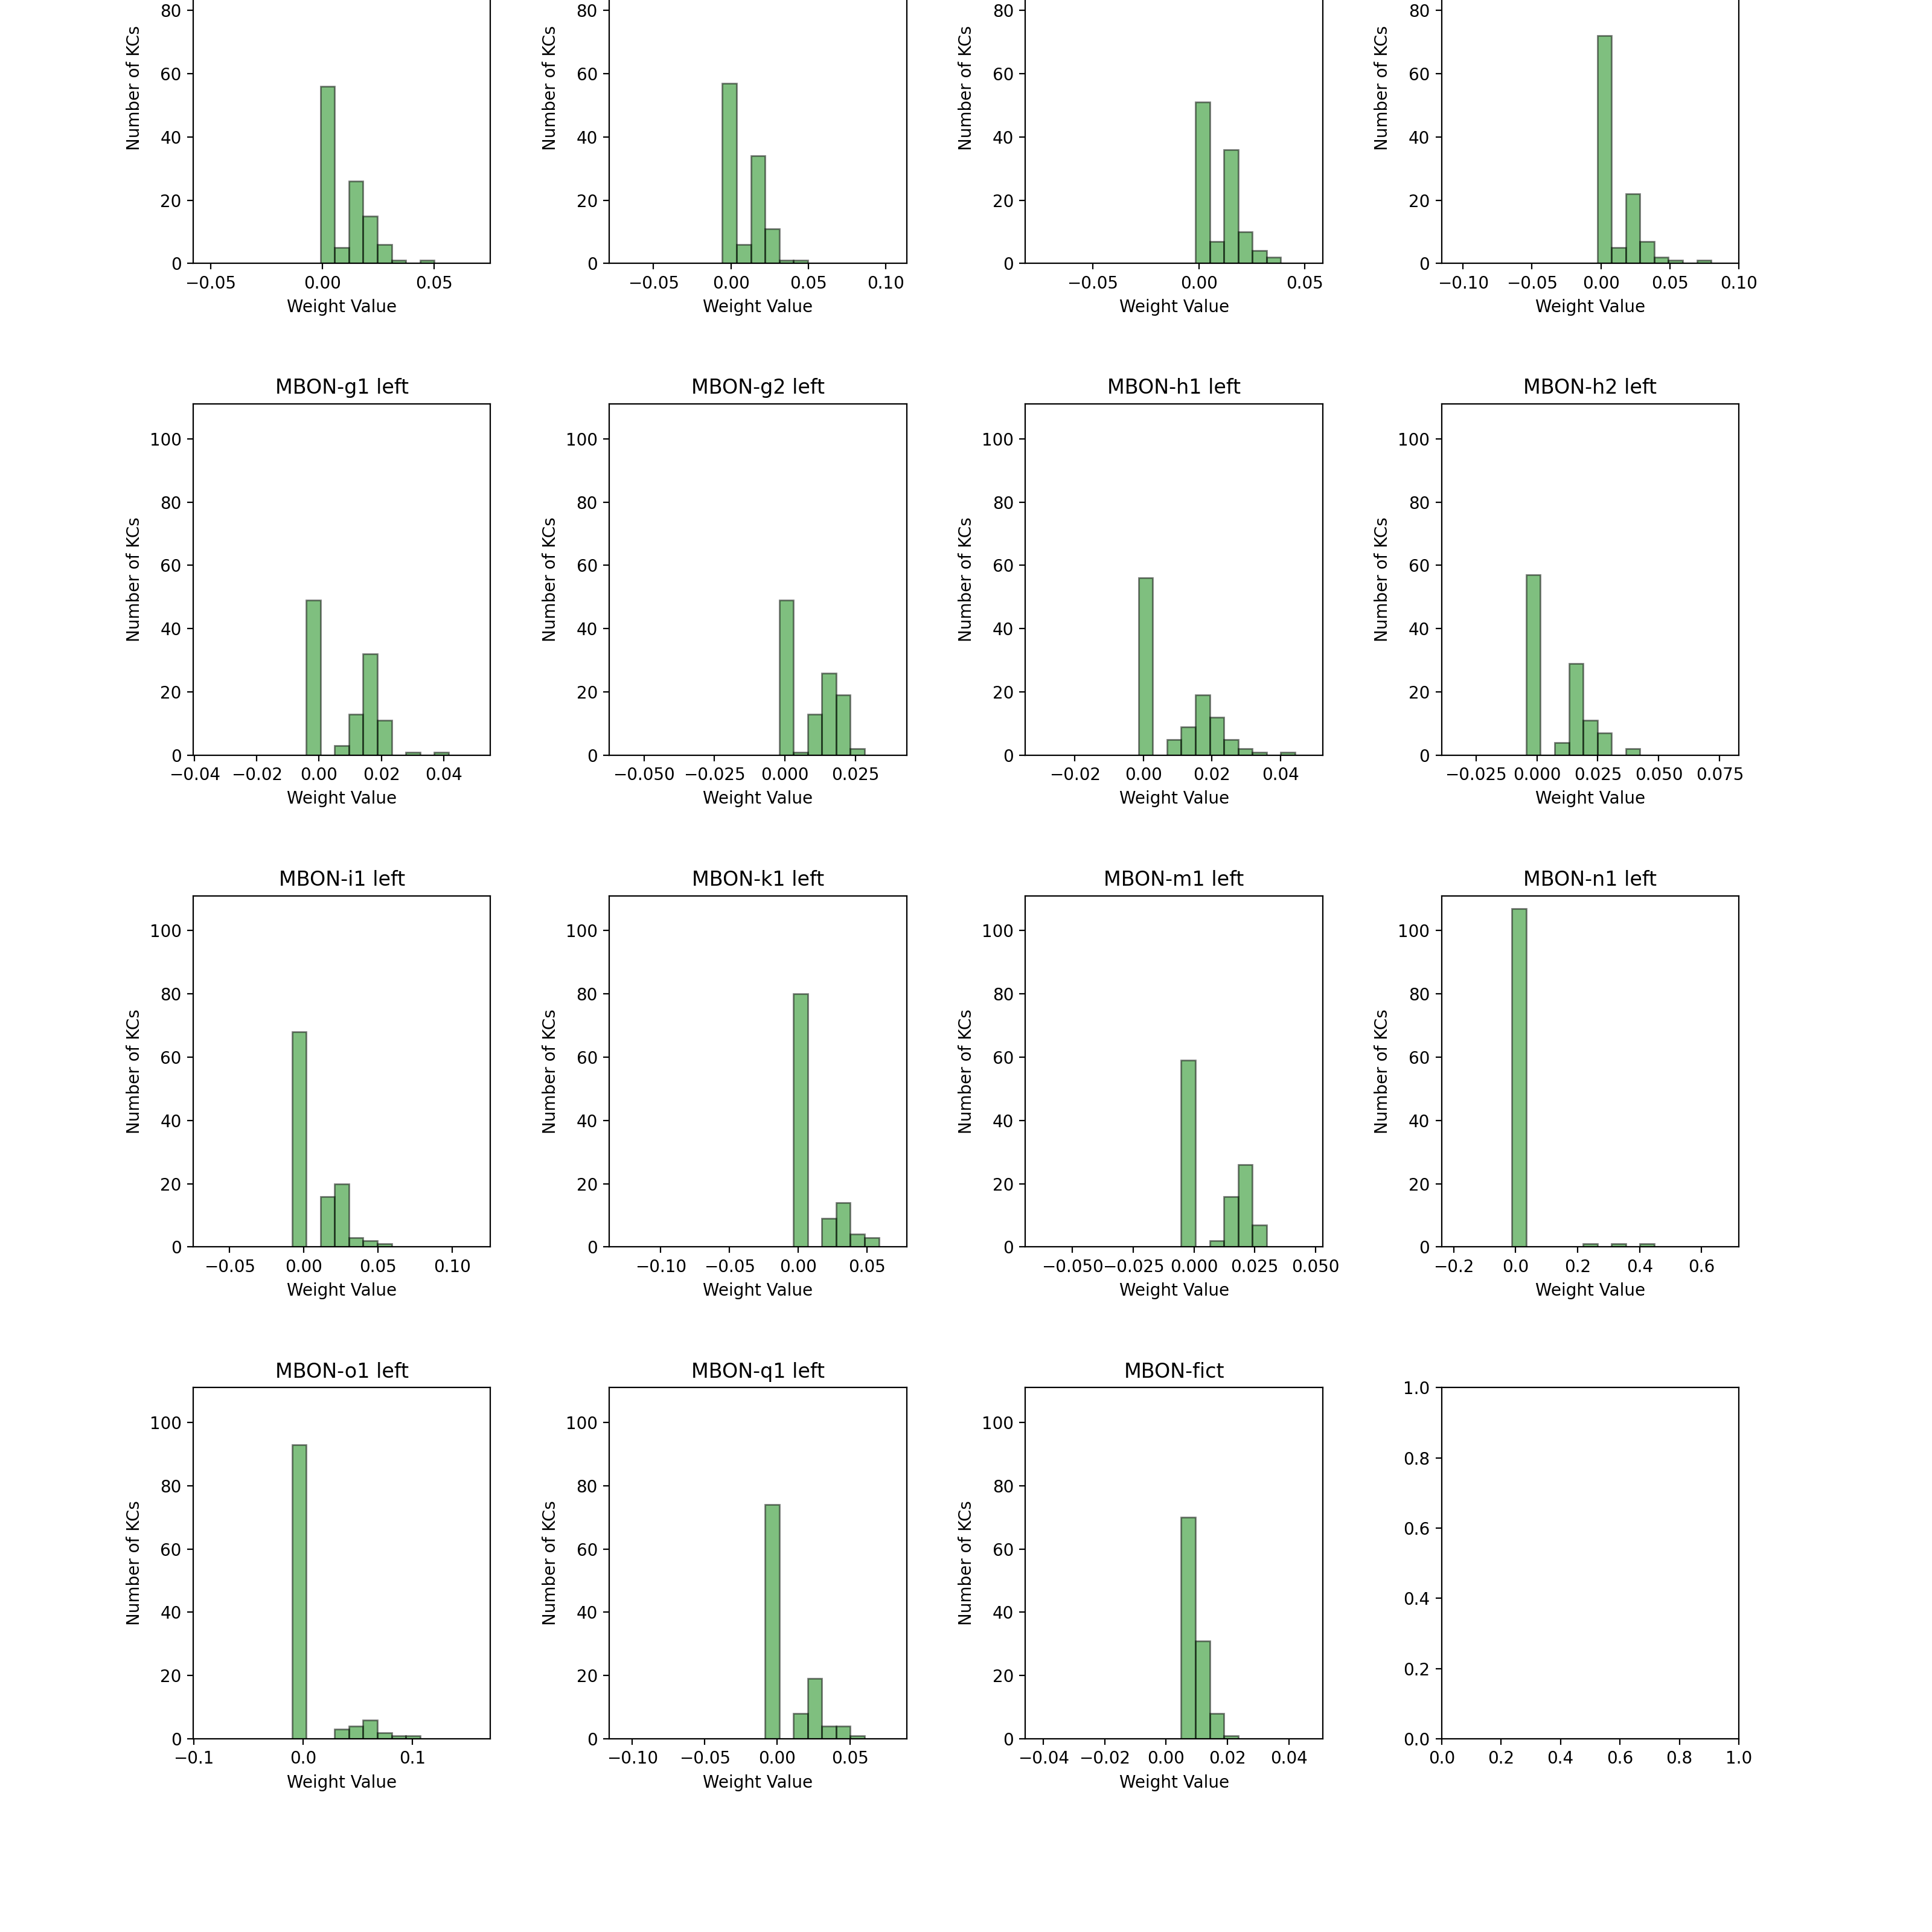

In [212]:
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)
    
# HISTOGRAM OF THE DISTRIBUTION OF MBON WEIGHTS VS NUM OF KCS
figure, axis = plt.subplots(5, 4, figsize=(16,16))
avg_final_weights = np.mean(abs(final_weights0), axis=0)

a = 0
for i in range(5):
    for j in range(4):
        if (a != 19):
            x = np.zeros((3, num_kcs))
            x[0] = kc_mbon.iloc[:,a]
            x[1] = final_weights[0, :, a]
            x[2] = avg_final_weights[:, a]
            
            # initial weights
#             axis[i, j].hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='initial')
            
            # after 1 run of training
#             axis[i, j].hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='1 run')
            
            # avg of 10 runs
            axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')
            
            axis[i, j].set_title(kc_mbon.columns[a])
            axis[i, j].set_ylim(0, 111)
            axis[i, j].set_xlabel('Weight Value')
            axis[i, j].set_ylabel('Number of KCs')
        a += 1
        
axis[0, 0].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

<IPython.core.display.Javascript object>


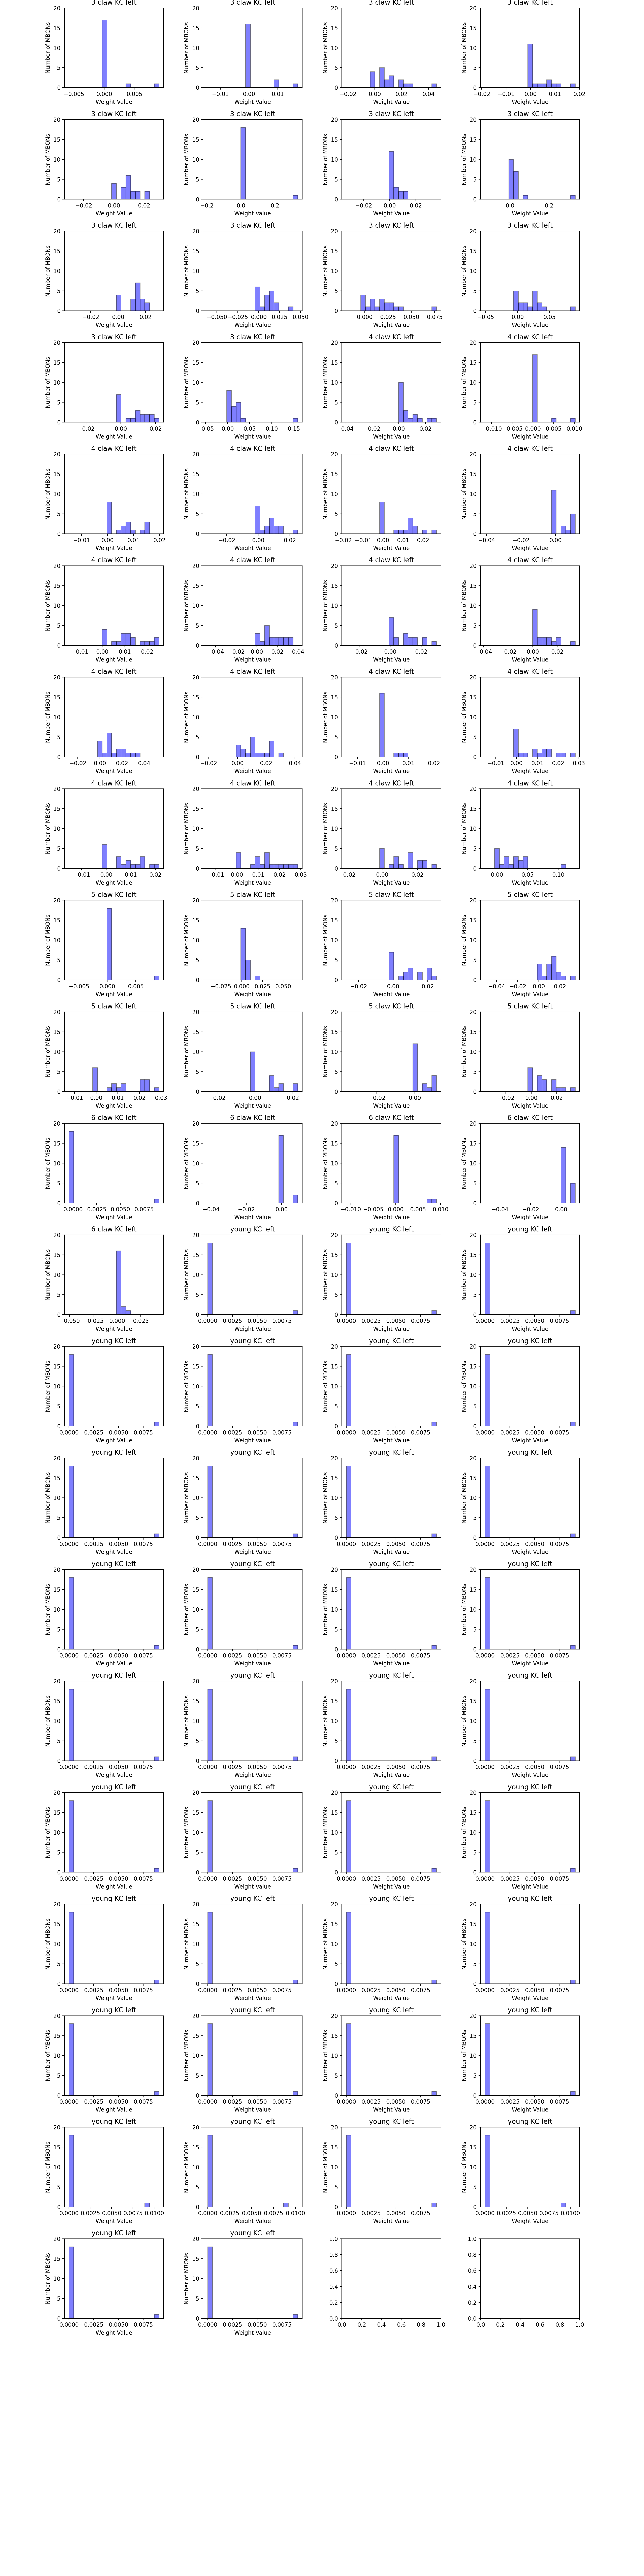

In [210]:
with open('C:/Users/Katherine Xie/RiseProject/run18-control-remove0KC-weightsum1/final-weights18.pkl', 'rb') as f:
    final_weights0 = pickle.load(f)
    
# average final weights over 10
avg_final_weights = np.mean(final_weights0, axis=0)

# HISTOGRAM OF THE DISTRIBUTION OF KC WEIGHTS VS NUM OF MBONS
figure, axis = plt.subplots(28, 4, figsize=(16,64))

a = 0
for i in range(28):
    for j in range(4):
        if a < 110:
            # initial weights
            x = np.zeros((3, num_mbons))
            x[0] = kc_mbon.iloc[a]
            x[1] = final_weights0[0, a]
            x[2] = avg_final_weights[a]

            axis[i, j].hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='initial')

            # final weights after 1 training run
#             axis[i, j].hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='1 run')

            # final weights avgeraged over 10 training runs
#             axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')

            axis[i, j].set_title(kc_mbon.index[a])
            axis[i, j].set_xlabel('Weight Value')
            axis[i, j].set_ylabel('Number of MBONs')
            axis[i, j].set_ylim(0, 20)
        
        a += 1

axis[0, 0].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

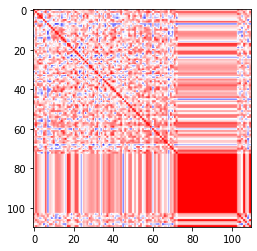

In [34]:
# HEAT MAP OF SPEARMAN CORRELATION COEFFICIENT OF TOTAL WEIGHTS (110 X 110)

total_weight_corr, corr_p = st.spearmanr(total_weights)
plt.figure()
plt.imshow(total_weight_corr, cmap="bwr", clim=(-1,1))

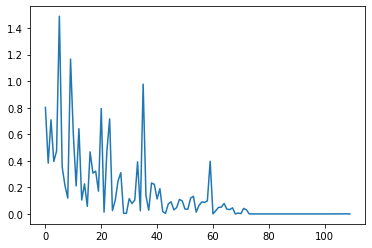

In [41]:
# GRAPH OF KCS VS. VARIANCE IN TOTAL WEIGHTS
new_total_weights = np.concatenate((total_weights[0:7], total_weights[8:10]), axis=0)

total_weight_var = np.var(new_total_weights, axis=0)

plt.figure()
plt.plot(total_weight_var)

In [102]:
# prints KC connections
print("number of KC connections:")
for j in range(num_mbons):
    conn = kc_mbon.to_numpy()[:,j].sum()
#     if (conn == 0):
    print("{}: {}".format(kc_mbon.columns[j], conn))

number of KC connections:
MBON-a1 left: 280
MBON-a2 left: 438
MBON-b1 left: 354
MBON-b2 left: 356
MBON-c1 left: 1154
MBON-d1 left: 409
MBON-e1 left: 629
MBON-e2 left: 133
MBON-g1 left: 513
MBON-g2 left: 470
MBON-h1 left: 289
MBON-h2 left: 385
MBON-i1 left: 187
MBON-k1 left: 87
MBON-m1 left: 177
MBON-n1 left: 6
MBON-o1 left: 63
MBON-q1 left: 143


In [37]:
# prints number of presynaptic KCs for each MBON
print("number of KC connections:")
for j in range(num_mbons):
    conn = bool_synapses[:,j].sum()
#     if (conn == 0):
    print("{}: {}".format(kc_mbon.columns[j], conn))

number of KC connections:
MBON-a1 left: 55
MBON-a2 left: 63
MBON-b1 left: 46
MBON-b2 left: 47
MBON-c1 left: 54
MBON-d1 left: 53
MBON-e1 left: 59
MBON-e2 left: 38
MBON-g1 left: 61
MBON-g2 left: 61
MBON-h1 left: 54
MBON-h2 left: 53
MBON-i1 left: 42
MBON-k1 left: 30
MBON-m1 left: 51
MBON-n1 left: 3
MBON-o1 left: 17
MBON-q1 left: 36
MBON-fict: 110


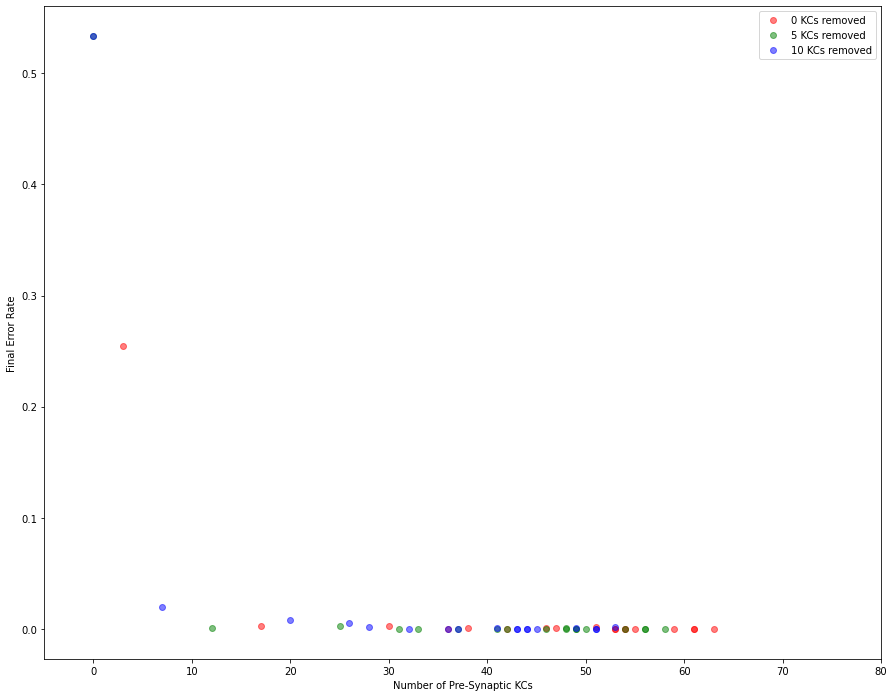

In [20]:
# NUMBER OF PRESYNAPTIC KCS VS. FINAL ERROR RATE (REMOVED 0, 5, 10, 20 KCS)
# FOR ALL -> SUM OF WEIGHTS = 2

plt.figure(figsize=(15,12))
sums = bool_synapses.sum(axis=0)

# 0 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run9-remove0KC/all-error-rates9.pkl', 'rb') as f:
    error_rates_remove0 = pickle.load(f)

avg_error_rates0 = np.mean(error_rates_remove0, axis=0)
x0 = sums # number of synapses
y0 = avg_error_rates0[-1,0:19] # final error rate

plt.plot(x0, y0, 'ro', alpha=0.5, label="0 KCs removed")

# 5 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run8-remove5KC/all-error-rates8.pkl', 'rb') as f:
    error_rates_remove5 = pickle.load(f)

avg_error_rates5 = np.mean(error_rates_remove5, axis=0)
temp = np.where(sums - 5 < 0, 0, sums)
x5 = np.subtract(temp, 5, where=temp>0) # number of synapses
y5 = avg_error_rates5[-1,0:19] # final error rate

plt.plot(x5, y5, 'go', alpha=0.5, label="5 KCs removed")

# 10 KCs removed
with open('C:/Users/Katherine Xie/RiseProject/run6-remove10KC/all-error-rates6.pkl', 'rb') as f:
    error_rates_remove10 = pickle.load(f)

avg_error_rates10 = np.mean(error_rates_remove10, axis=0)
temp = np.where(sums - 10 < 0, 0, sums)
x10 = np.subtract(temp, 10, where=temp>0) # number of synapses
y10 = avg_error_rates10[-1,0:19] # final error rate

plt.plot(x10, y10, 'bo', alpha=0.5, label="10 KCs removed")

# # 20 KCs removed
# with open('C:/Users/Katherine Xie/RiseProject/run7-remove20KC/all-error-rates7.pkl', 'rb') as f:
#     error_rates_remove20 = pickle.load(f)

# avg_error_rates20 = np.mean(error_rates_remove20, axis=0)
# temp = np.where(sums - 20 < 0, 0, sums)
# x20 = np.subtract(temp, 20, where=temp>0) # number of synapses
# y20 = avg_error_rates20[-1,0:19] # final error rate

# plt.plot(x20, y20, 'ko', alpha=0.5, label="20 KCs removed")

plt.xlim([-5, 80])
plt.xlabel("Number of Pre-Synaptic KCs")
plt.ylabel("Final Error Rate")
plt.legend()

plt.show()

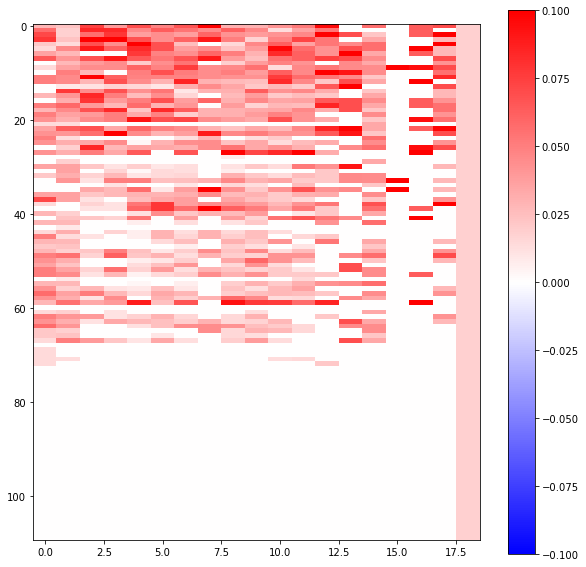

In [27]:
# HEAT MAP OF INITIAL KC WEIGHTS
plt.figure(figsize=(10,10))
c1 = plt.imshow(kc_mbon, cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c1)
plt.show()

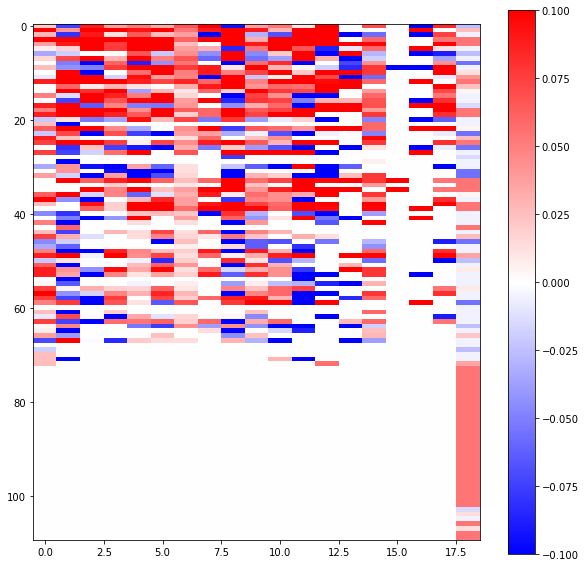

In [28]:
# HEAT MAP OF FINAL KC WEIGHTS AFTER 1 TRAINING RUN
plt.figure(figsize=(10,10))
c2 = plt.imshow(all_kc_weights[0], cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c2)
plt.show()

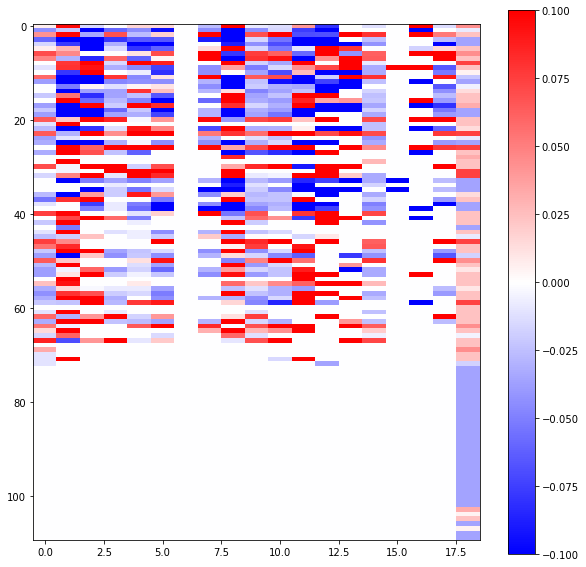

In [26]:
# HEAT MAP OF DIFFERENCE BETWEEN INITIAL AND FINAL WEIGHTS AFTER 1 TRAINING RUN
plt.figure(figsize=(10,10))
c3 = plt.imshow(kc_mbon - all_kc_weights[0], cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c3)
plt.show()

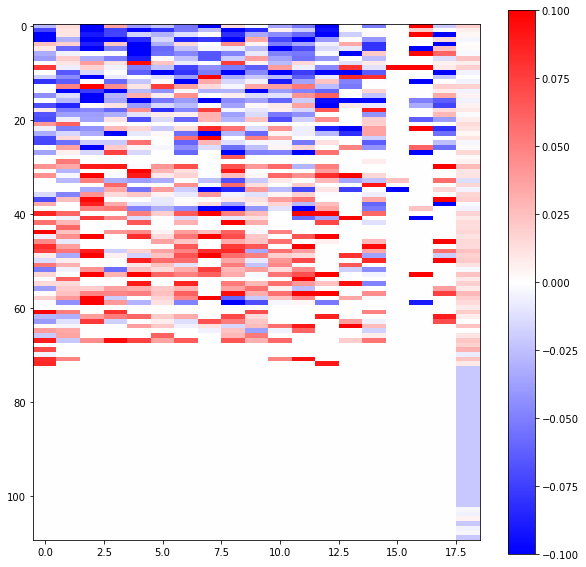

In [30]:
# HEAT MAP OF THE DIFFERENCE BETWEEN INITIAL AND AVG FINAL WEIGHTS (OF 10 TRAINING RUNS)
plt.figure(figsize=(10,10))
average_weights = np.mean(all_kc_weights, axis=0)
c3 = plt.imshow(kc_mbon - average_weights, cmap="bwr", clim=(-.1,.1), aspect=.2)
plt.colorbar(c3)
plt.show()

[[0.         0.73391616 0.         0.         0.78321994 0.
  0.         0.80106683 0.75831087 0.         0.         0.82847171
  0.         0.8283931  0.         0.         0.         0.
  0.         0.         0.84908963 0.         0.78508999 0.79744726
  0.         0.         0.7609286  0.         0.79914053 0.
  0.         0.81487677 0.         0.80111201 0.         0.
  0.         0.80945249 0.78039738 0.        ]
 [0.83681847 0.83396142 0.81114455 0.85593349 0.         0.79879929
  0.84906401 0.         0.         0.71214645 0.83441513 0.
  0.8618101  0.         0.82491634 0.71471084 0.         0.77173135
  0.         0.         0.80045173 0.83298372 0.76207571 0.83006051
  0.81842822 0.79590501 0.84677346 0.83391529 0.77915599 0.83840152
  0.80077369 0.75827217 0.         0.74403512 0.         0.75317056
  0.85992115 0.80759039 0.9314565  0.70456126]
 [0.         0.         0.71950098 0.         0.80630014 0.74692426
  0.         0.         0.         0.76623345 0.77177886 0.778

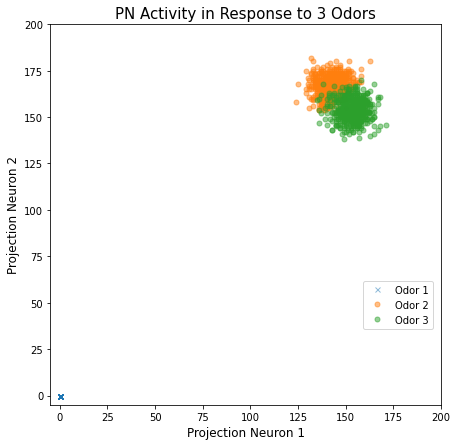

In [18]:
# PRINT PN ACTIVITY DISTRIBUTION (ODOR RESPONSE DISTRIBUTION)
import seaborn as sns
import itertools
N = 3
num_pns = 40
num_inputs = 50000
spikes = 200
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/input-means1.pkl', 'rb') as f:
    input_means = pickle.load(f)
    
response = input_means
print(response)

bool_response = np.where(input_means > 0, 1, 0)
print(bool_response)

all_inputs = np.zeros((num_inputs, num_pns))
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns))
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs
    
# print("pn_inputs shape: {}".format(pn_inputs.shape))

# odor_outputs = np.zeros((N, num_mbons))
# odor_outputs[0] = [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]
# odor_outputs[1] = [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
# odor_outputs[2] = [1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
# odor_outputs[3] = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]
# odor_outputs[4] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
# odor_outputs[5] = [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
# odor_outputs[6] = [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
# odor_outputs[7] = [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
# odor_outputs[8] = [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
# odor_outputs[9] = [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]

fire = np.ones((N, num_inputs//N))
fire[2] = 0
fire = fire.astype(int)
# print(fire)

categories = ['x', 'o', 'o']
# categories = ['o', 'o', 'o', 'x', 'o', 'o', 'x', 'o', 'o', 'o']
markers = itertools.cycle(('+', '+', 'o'))
labels = []
for i in range(N):
    labels.append("Odor {}".format(i+1))

# plotting
# fig, ax = plt.subplots(1, 1, figsize = (7,5))
plt.figure(figsize=(7,7))
for i in range(N):
    plt.plot(pn_inputs[i, 0:500, 9], pn_inputs[i, 0:500, 10], marker = categories[i], markersize=5, alpha = 0.5,
             label = labels[i], linestyle = '')
#     sns.scatterplot(x = pn_inputs[i, :, 9], y = pn_inputs[i, :, 10], s = 100, palette = 'Accent', style = categories[i])
plt.xlim(-5, 200)
plt.ylim(-5, 200)
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles, categories)
plt.legend(loc=(0.8,0.2))
plt.title('PN Activity in Response to {} Odors'.format(N), fontsize=15)
plt.xlabel('Projection Neuron 1', fontsize=12)
plt.ylabel('Projection Neuron 2', fontsize=12)
plt.show()

In [8]:
R = 10
E = 5
all_kcs_removed = [[[] for _ in range(R)] for _ in range(E)]
all_kcs_removed[1][0] = "hi"
print(all_kcs_removed)

[[[], [], [], [], [], [], [], [], [], []], ['hi', [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []]]
